# 1. Fitting Ne lines in a loop
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'0.0.69dev'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\spectra'
spectra_path=DayFolder + '\spectra'
filetype='headless_txt'
# What is your file extension? .txt, .csv, .xlsx?
file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=False
prefix_str=' '
# Does your instrument have TruPower?
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower)


In [4]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad', 'mol'], sort=False)

Ne_files

['Ne_lines_12_2.txt',
 'Ne_lines_1_1.txt',
 'Ne_lines_1_2.txt',
 'Ne_lines_2_1.txt',
 'Ne_lines_2_2.txt',
 'Ne_lines_3_1.txt',
 'Ne_lines_3_2.txt',
 'Ne_lines_4_1.txt',
 'Ne_lines_4_2.txt',
 'Ne_lines_5_1.txt',
 'Ne_lines_5_2.txt',
 'Ne_lines_6_1.txt',
 'Ne_lines_6_2.txt',
 'Ne_lines_7_1.txt',
 'Ne_lines_7_2.txt',
 'Ne_lines_8_1.txt',
 'Ne_lines_8_2.txt',
 'Ne_lines_9_1.txt',
 'Ne_lines_9_2.txt',
 'Ne_lines_10_1.txt',
 'Ne_lines_10_2.txt',
 'Ne_lines_11_1.txt',
 'Ne_lines_11_2.txt',
 'Ne_lines_12_1.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.02 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
1           819.618059     5000.0                556.27662
9          1118.005523     5000.0                565.66588
16         1311.398741     5000.0                571.92248
19         1399.833669     5000.0                574.82985
23         1448.483158     7000.0                576.44188

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Entered Pos Line 1  \
0  330.477634  1118.005523  1448.483158                1117   

   Entered Pos Line 2  
0                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [14]:
i=3 # Select one file
filename=Ne_files[i] 
print(filename)

Ne_lines_2_1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height  Peak2_cent  Peak2_height  Peak1_prom  Peak2_prom
0     1117.29       11743.0     1448.29       64525.0     11333.0     64115.0

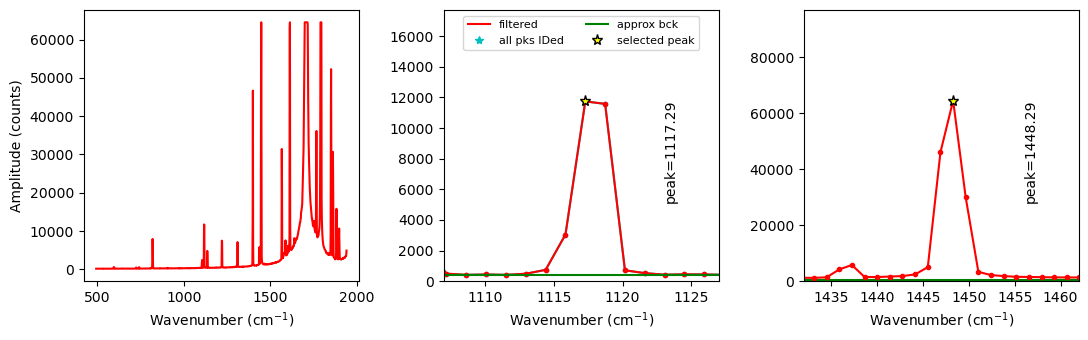

In [15]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

In [17]:
df_fit_params

Peak1_cent  Peak1_height  Peak2_cent  Peak2_height  Peak1_prom  Peak2_prom
0     1117.29       11743.0     1448.29       64525.0     11333.0     64115.0

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [18]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [20]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=1, LH_offset_mini=[2, 5],
pk1_sigma=1, pk2_sigma=1.5, y_range_baseline_pk1=500, y_range_baseline_pk2=5000,
lower_bck_pk1=(-80, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -20], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=15, x_span_pk1=[-5, 5], x_span_pk2=[-5, 5],
N_poly_pk2_baseline=2)

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  pk2_peak_cent  \
0  Ne_lines_2_1.txt         0.000231    0.000231    1448.044886   

   pk2_amplitude  pk2_sigma pk2_gamma  error_pk2  Peak2_Prop_Lor  \
0  200968.829088   1.427473      None     0.0628    1.595996e-11   

   pk1_peak_cent  ...  pk1_gamma  error_pk1 Peak1_Prop_Lor     deltaNe  \
0    1117.964524  ...       None   0.043479       0.276495  330.080362   

    Ne_Corr  Ne_Corr_min  Ne_Corr_max  residual_pk2  residual_pk1  \
0  1.001204     1.000881     1.001526   1674.825183      426.2963   

   residual_pk1+pk2  
0       2101.121483  

[1 rows x 22 columns]

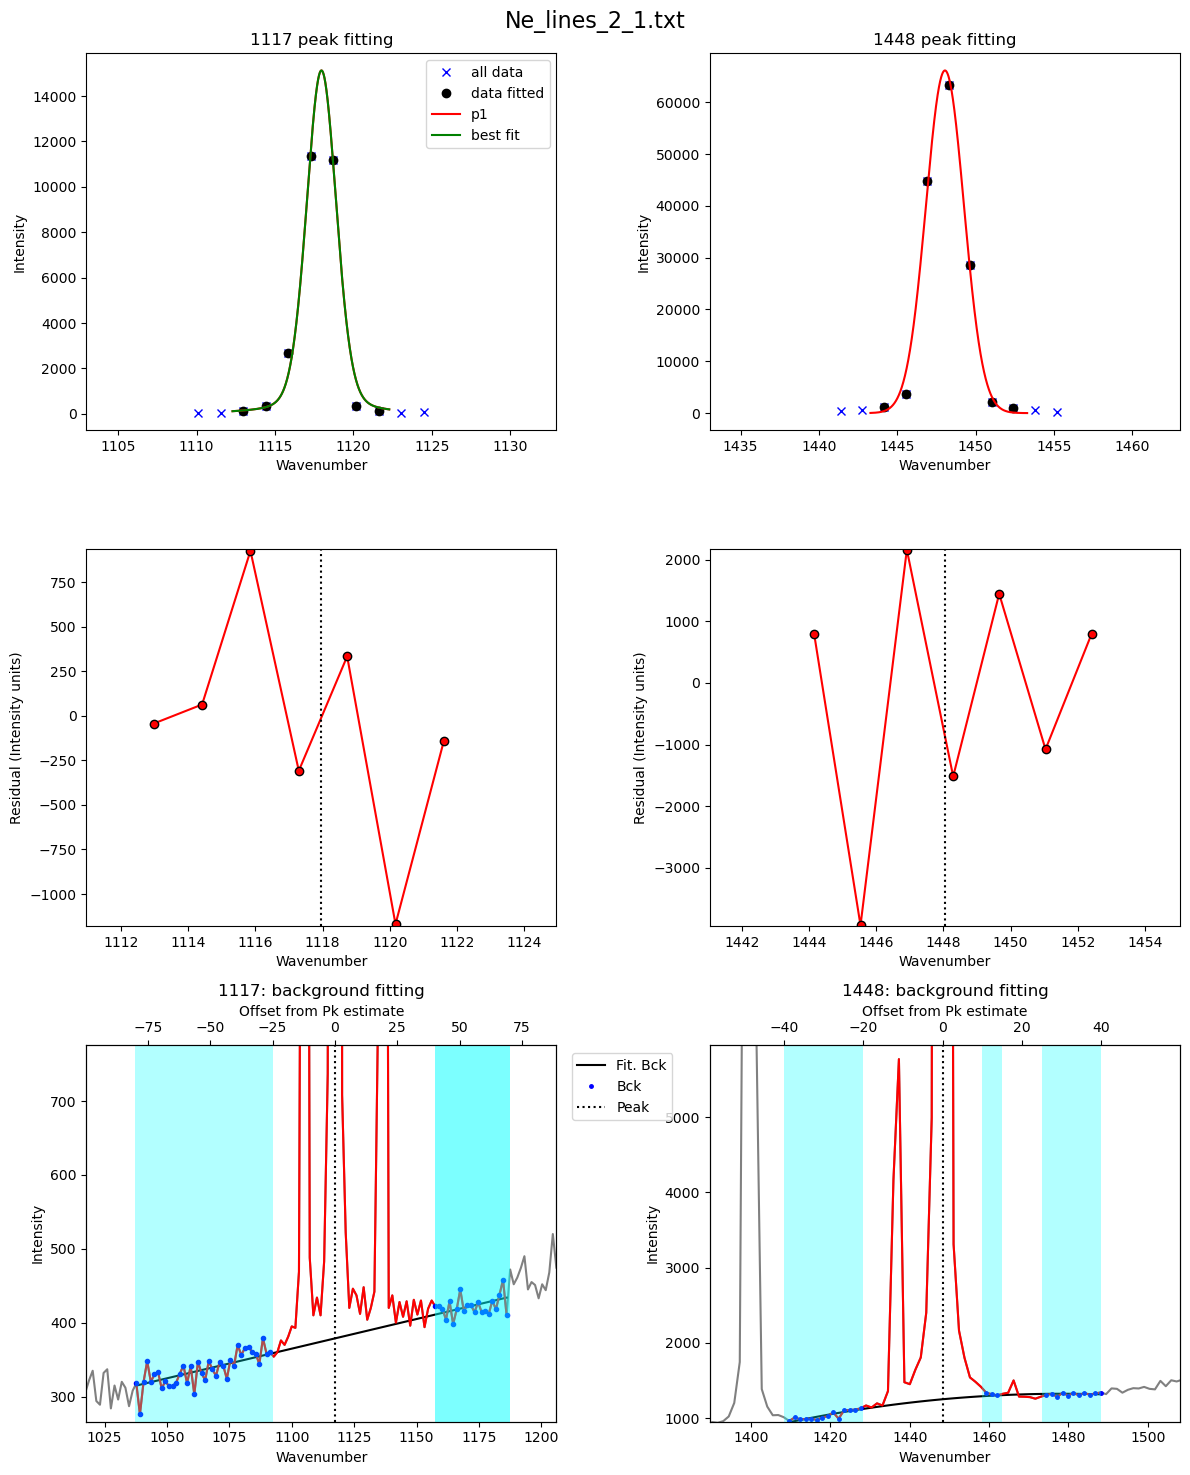

In [21]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=True)                                                                 
                                                                     
display(df_test_params)

In [22]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]
Ne_Config_est


Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=2, lower_bck_pk1=(-80, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70], lower_bck_pk2=[-40, -20], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40], peaks_1=1, DeltaNe_ideal=0    330.477634
Name: Ne_Split, dtype: float64, x_range_baseline_pk1=20, y_range_baseline_pk1=500, x_range_baseline_pk2=20, y_range_baseline_pk2=5000, pk1_sigma=1.1283175673214716, pk2_sigma=1.4274733376357949, x_range_peak=15, x_range_residual=7, LH_offset_mini=[2, 5], x_span_pk1=[-5, 5], x_span_pk2=[-5, 5])

## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/24 [00:00<?, ?it/s]

g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\ne_lines.py:1220: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ((ax3, ax2), (ax5, ax4), (ax1, ax0)) = plt.subplots(3,2, figsize = (12,15)) # adjust dimensions of figure here


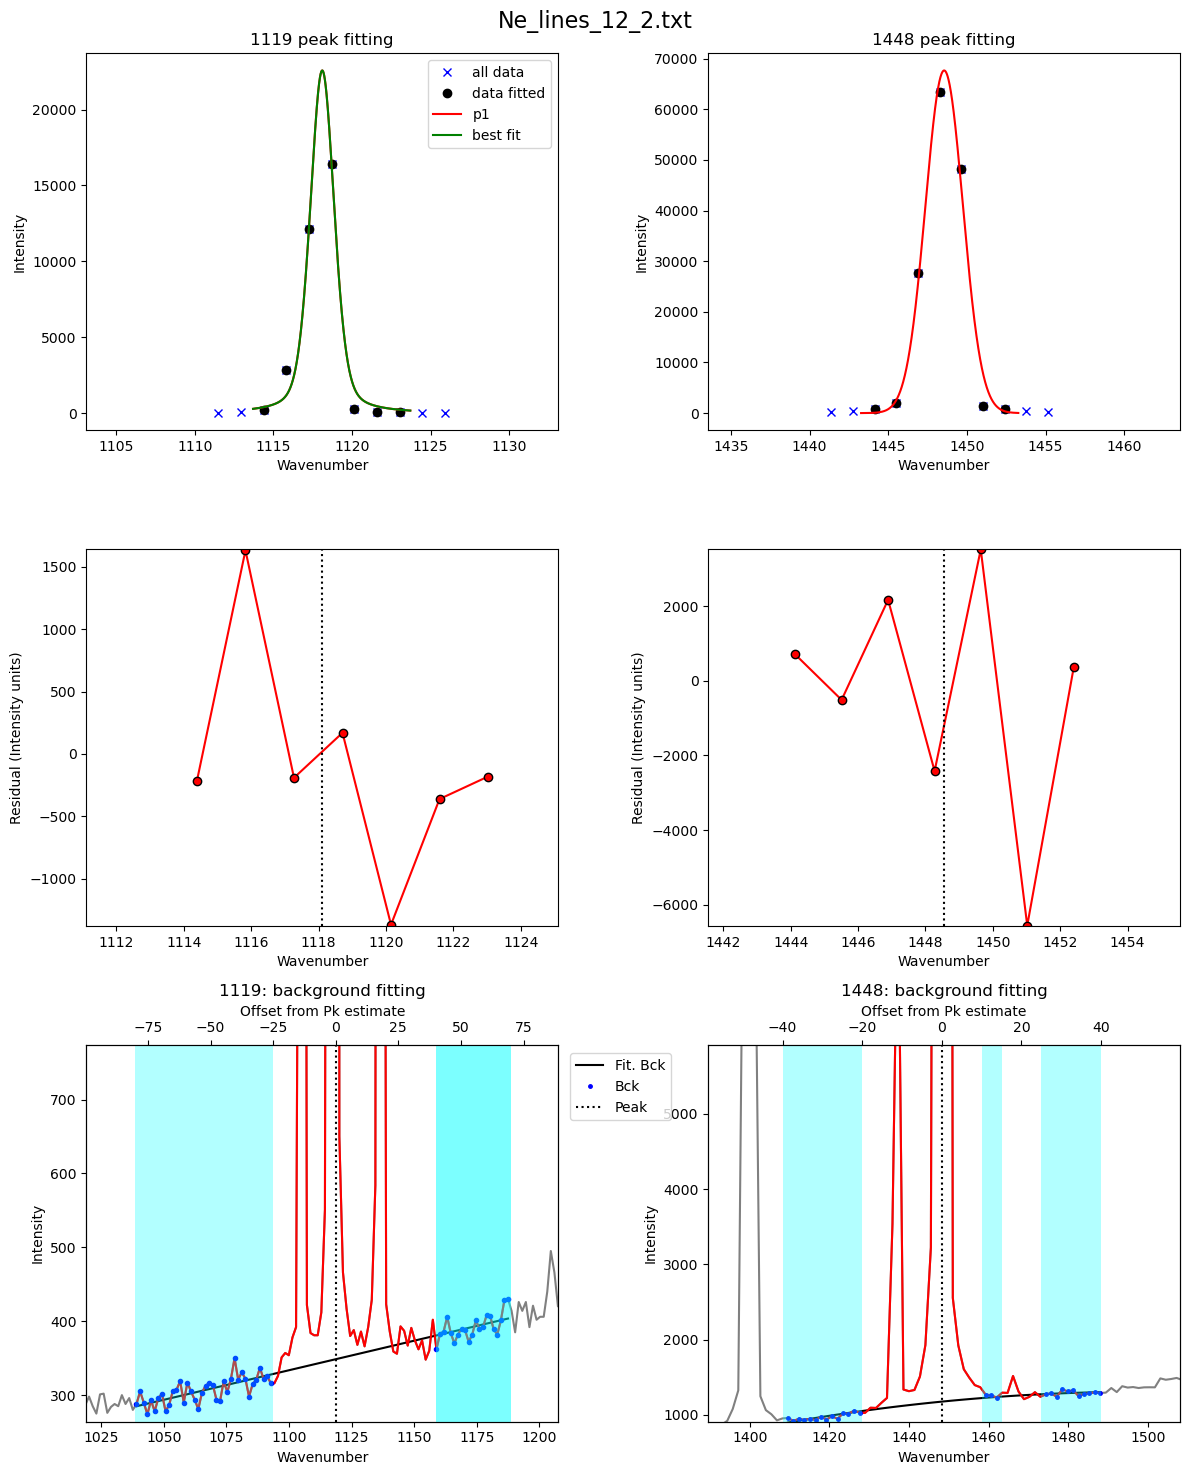

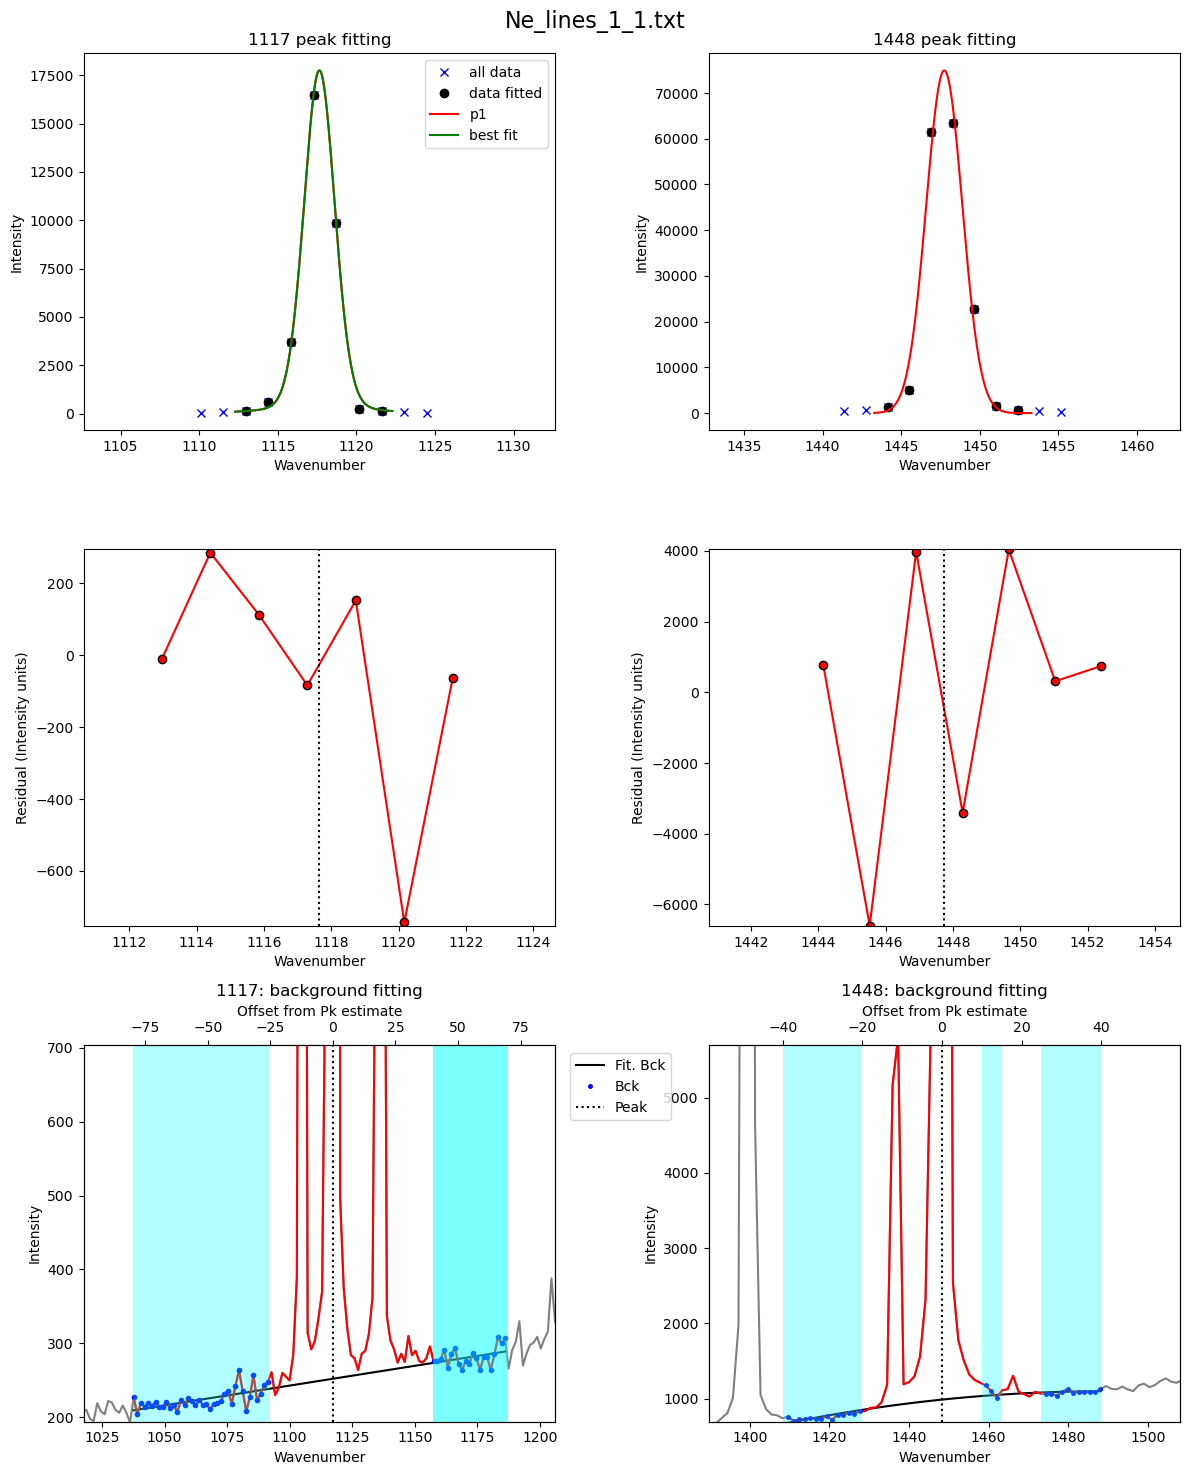

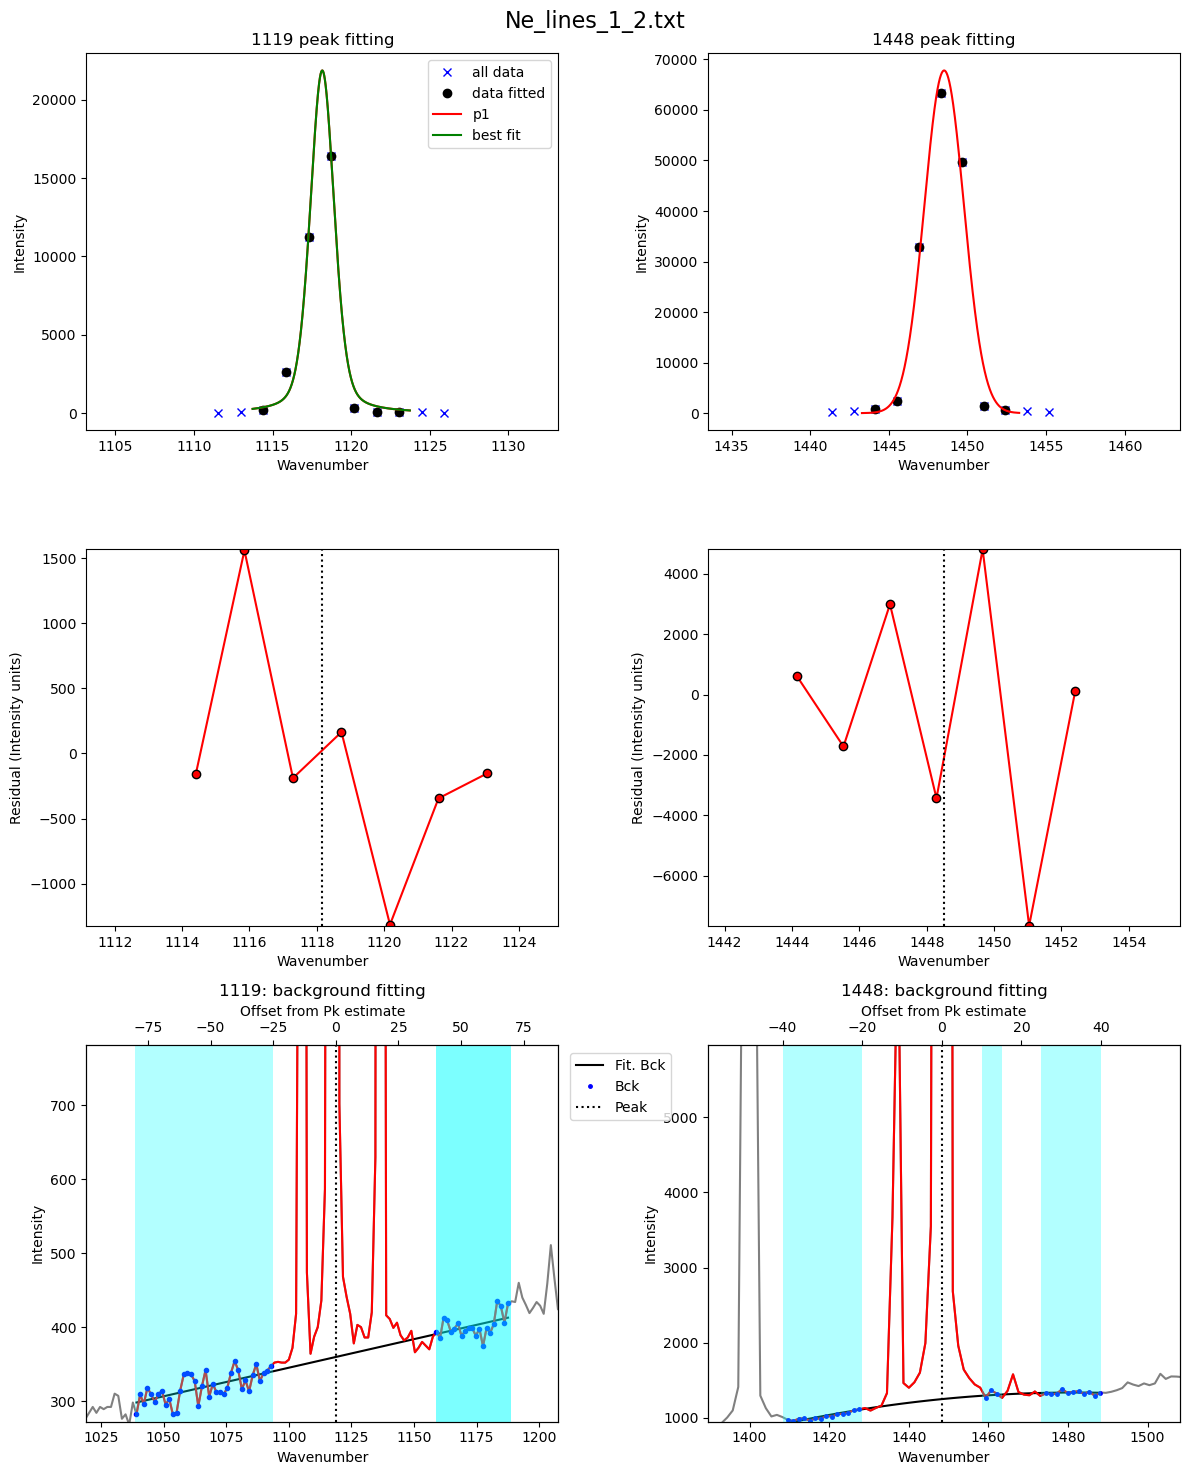

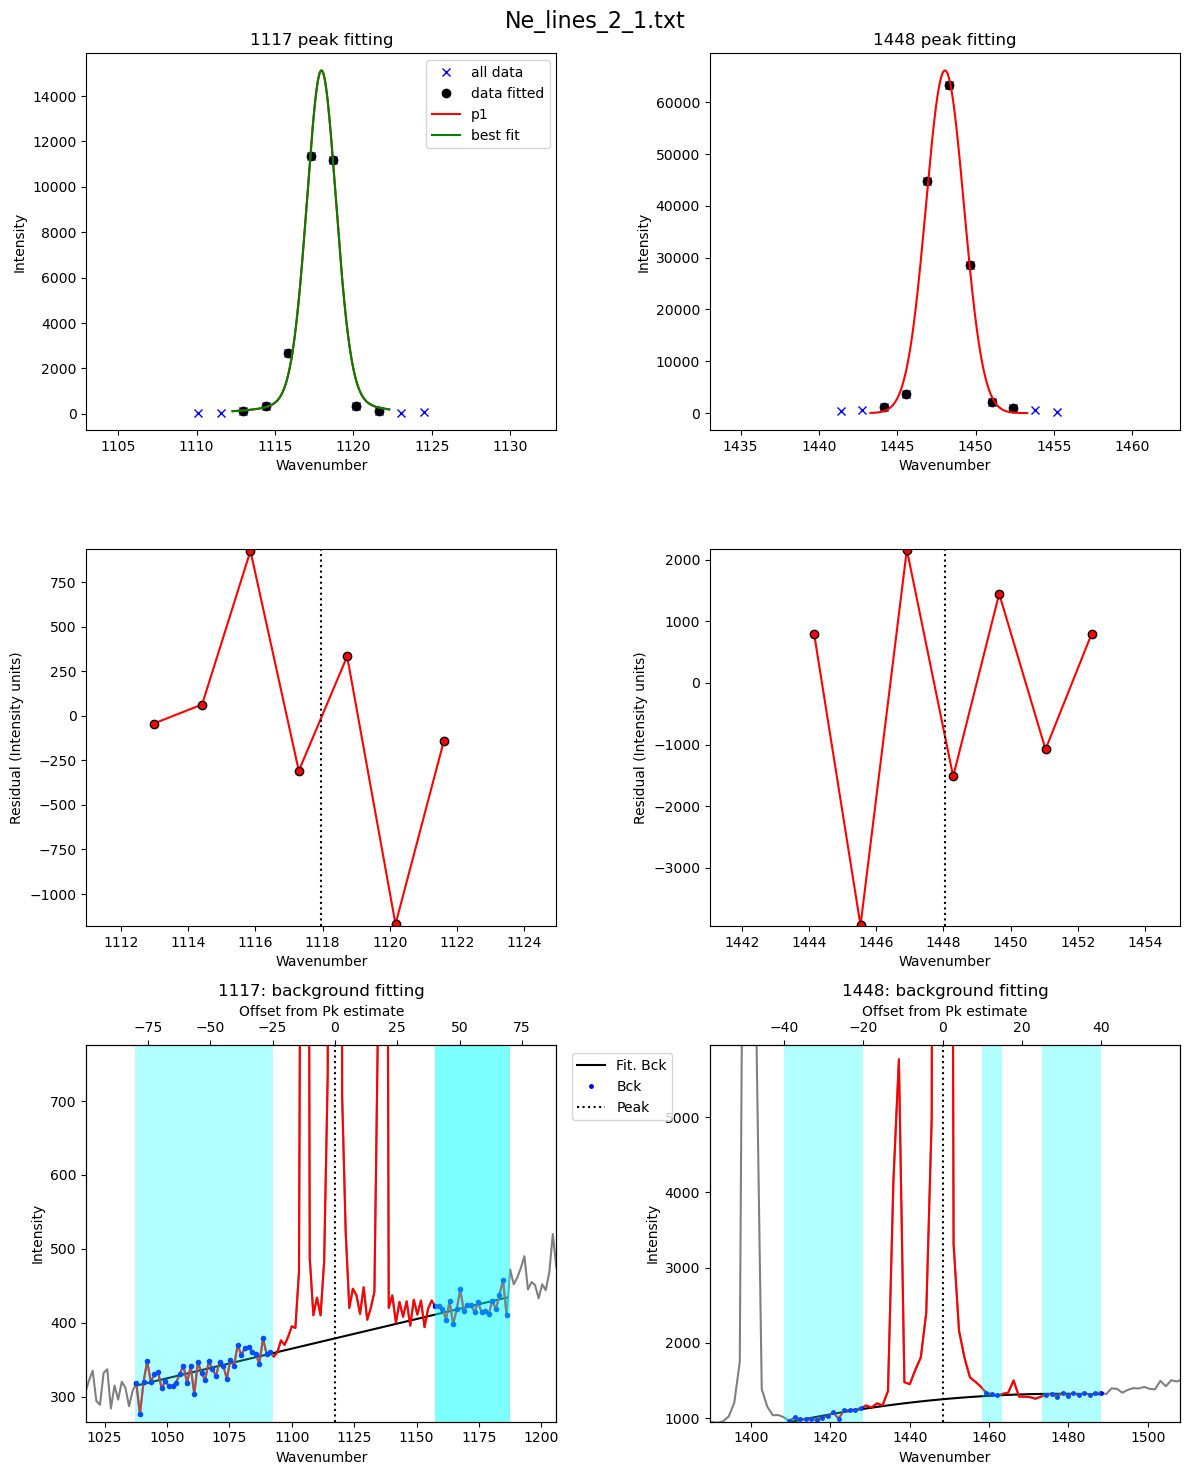

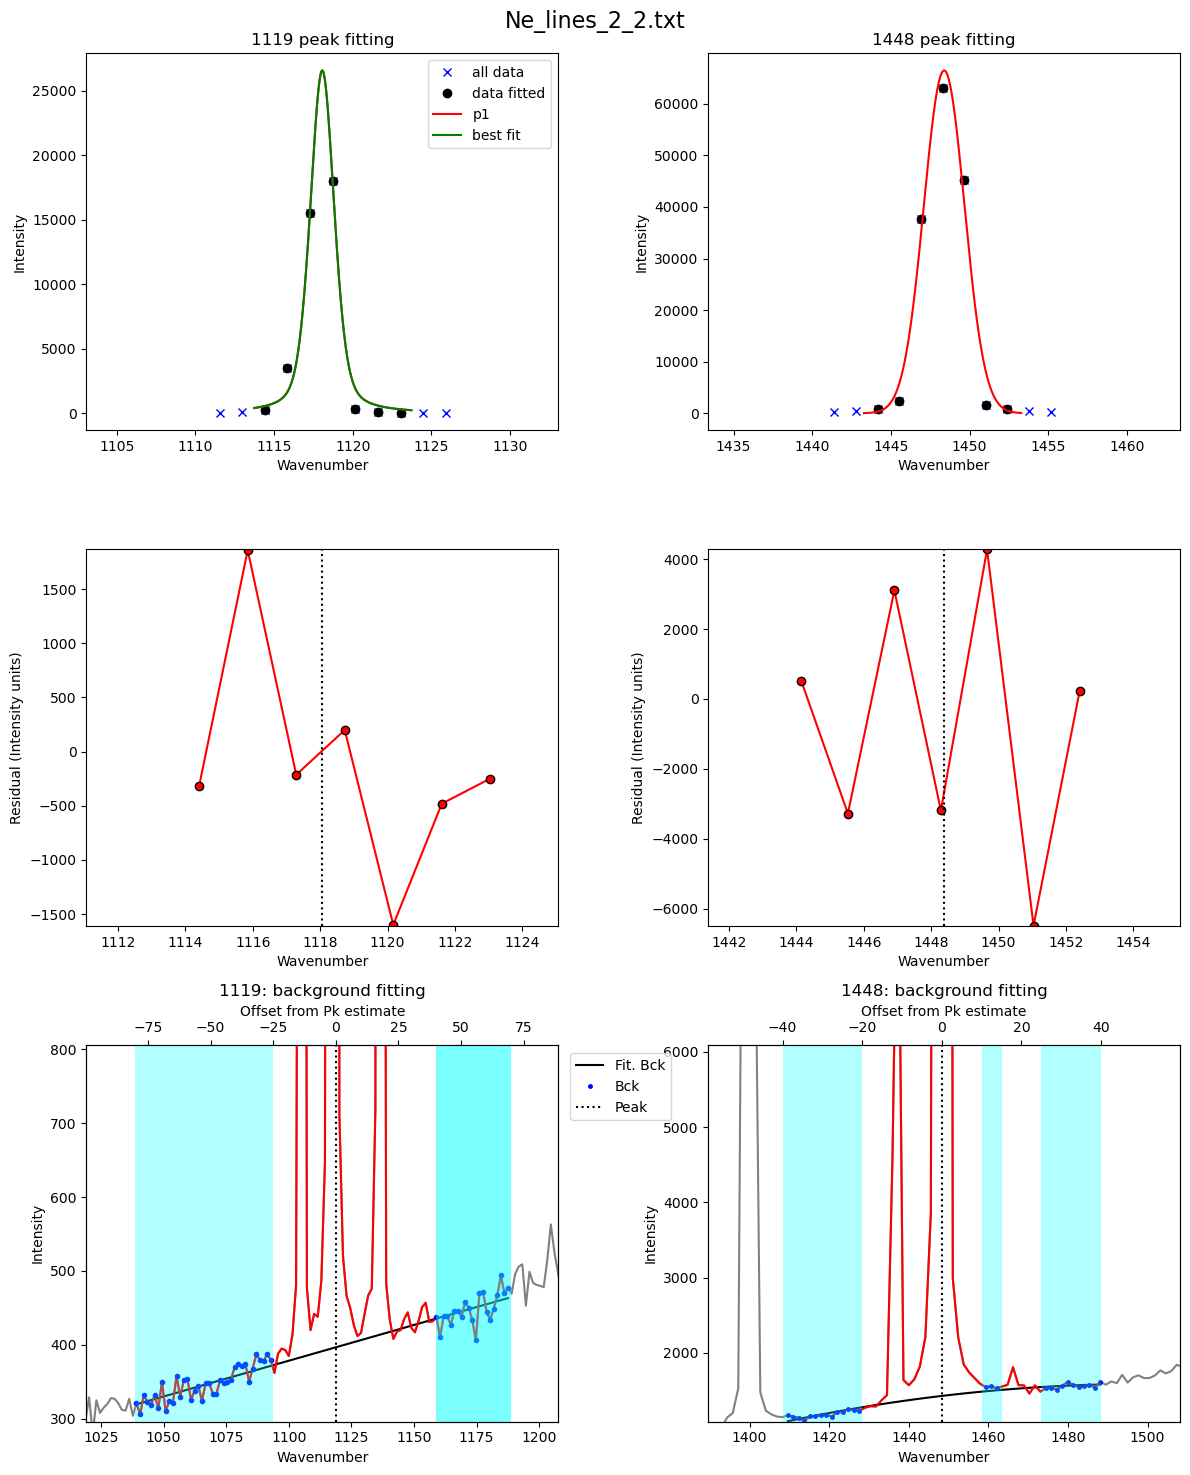

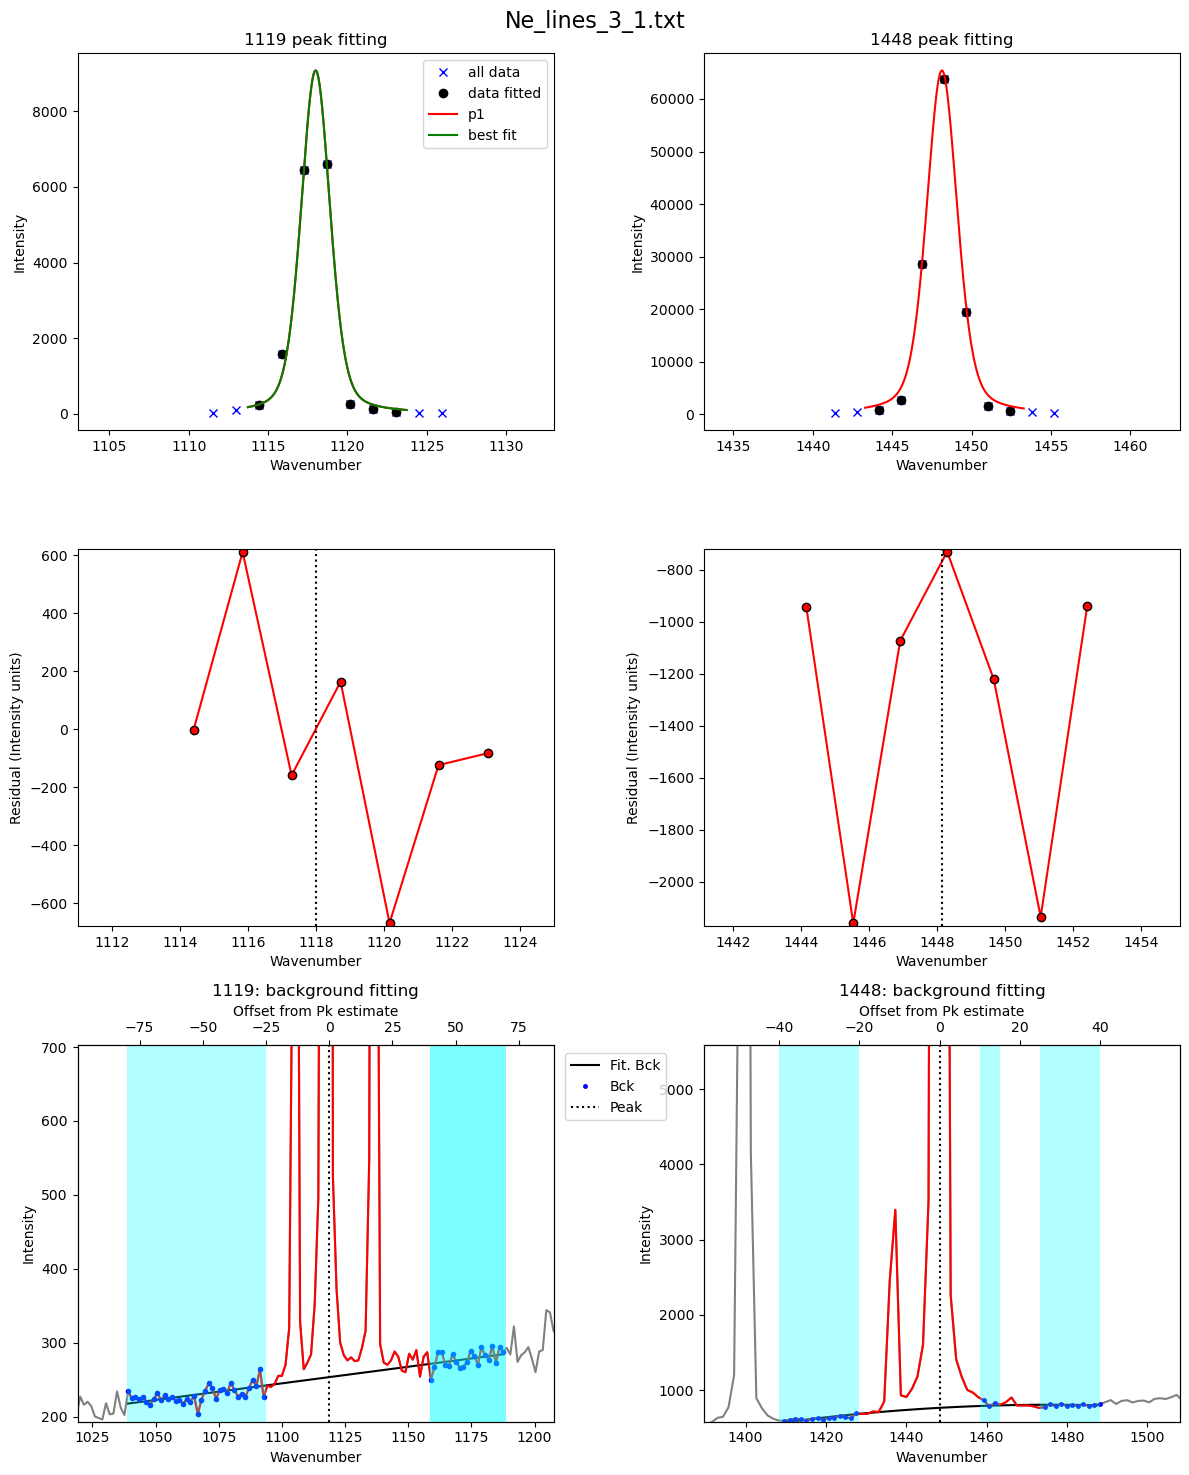

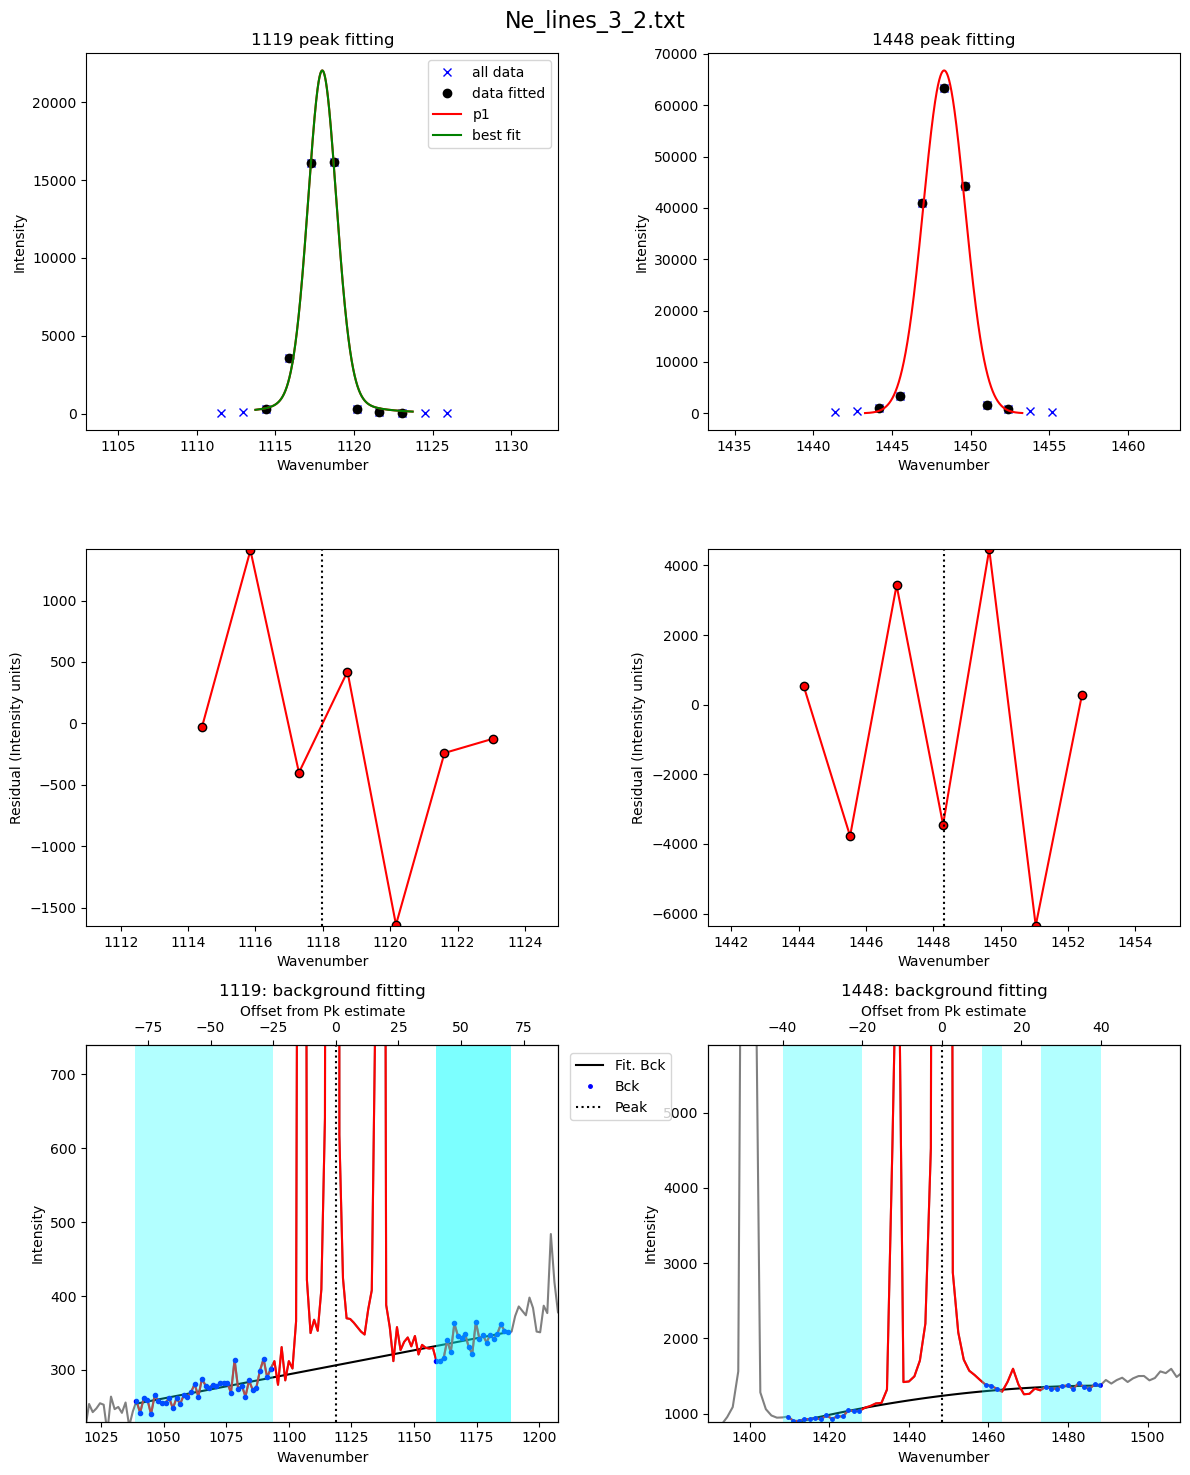

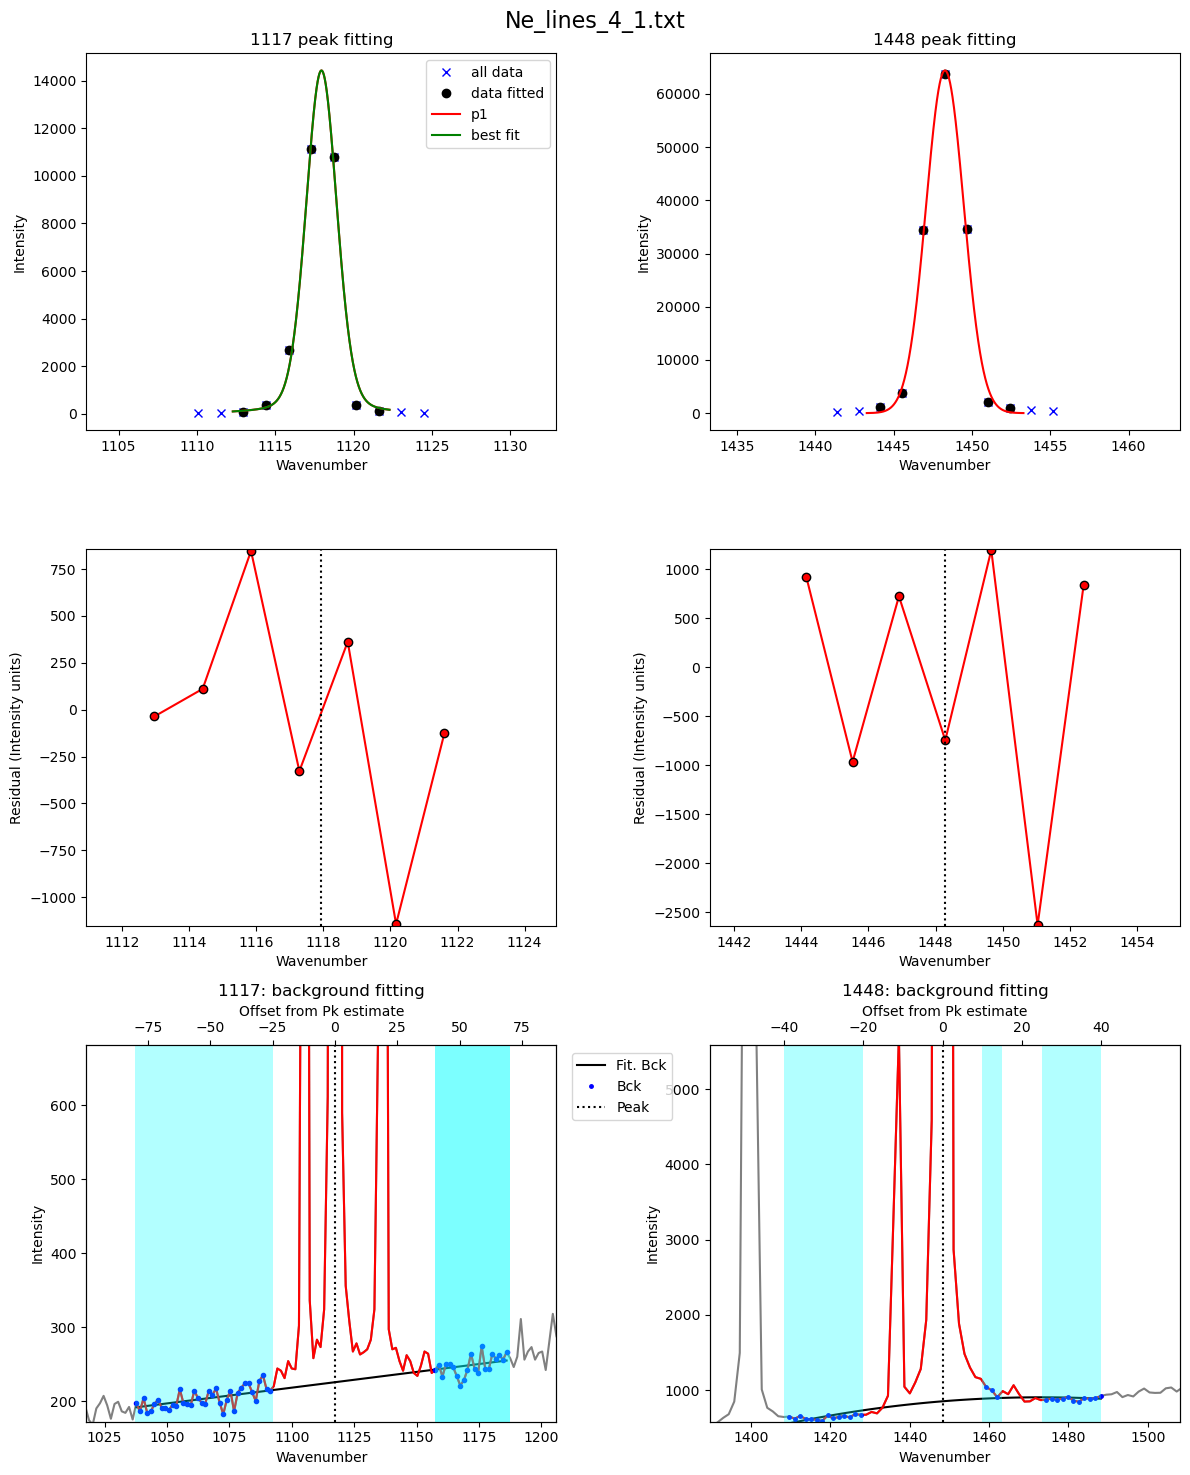

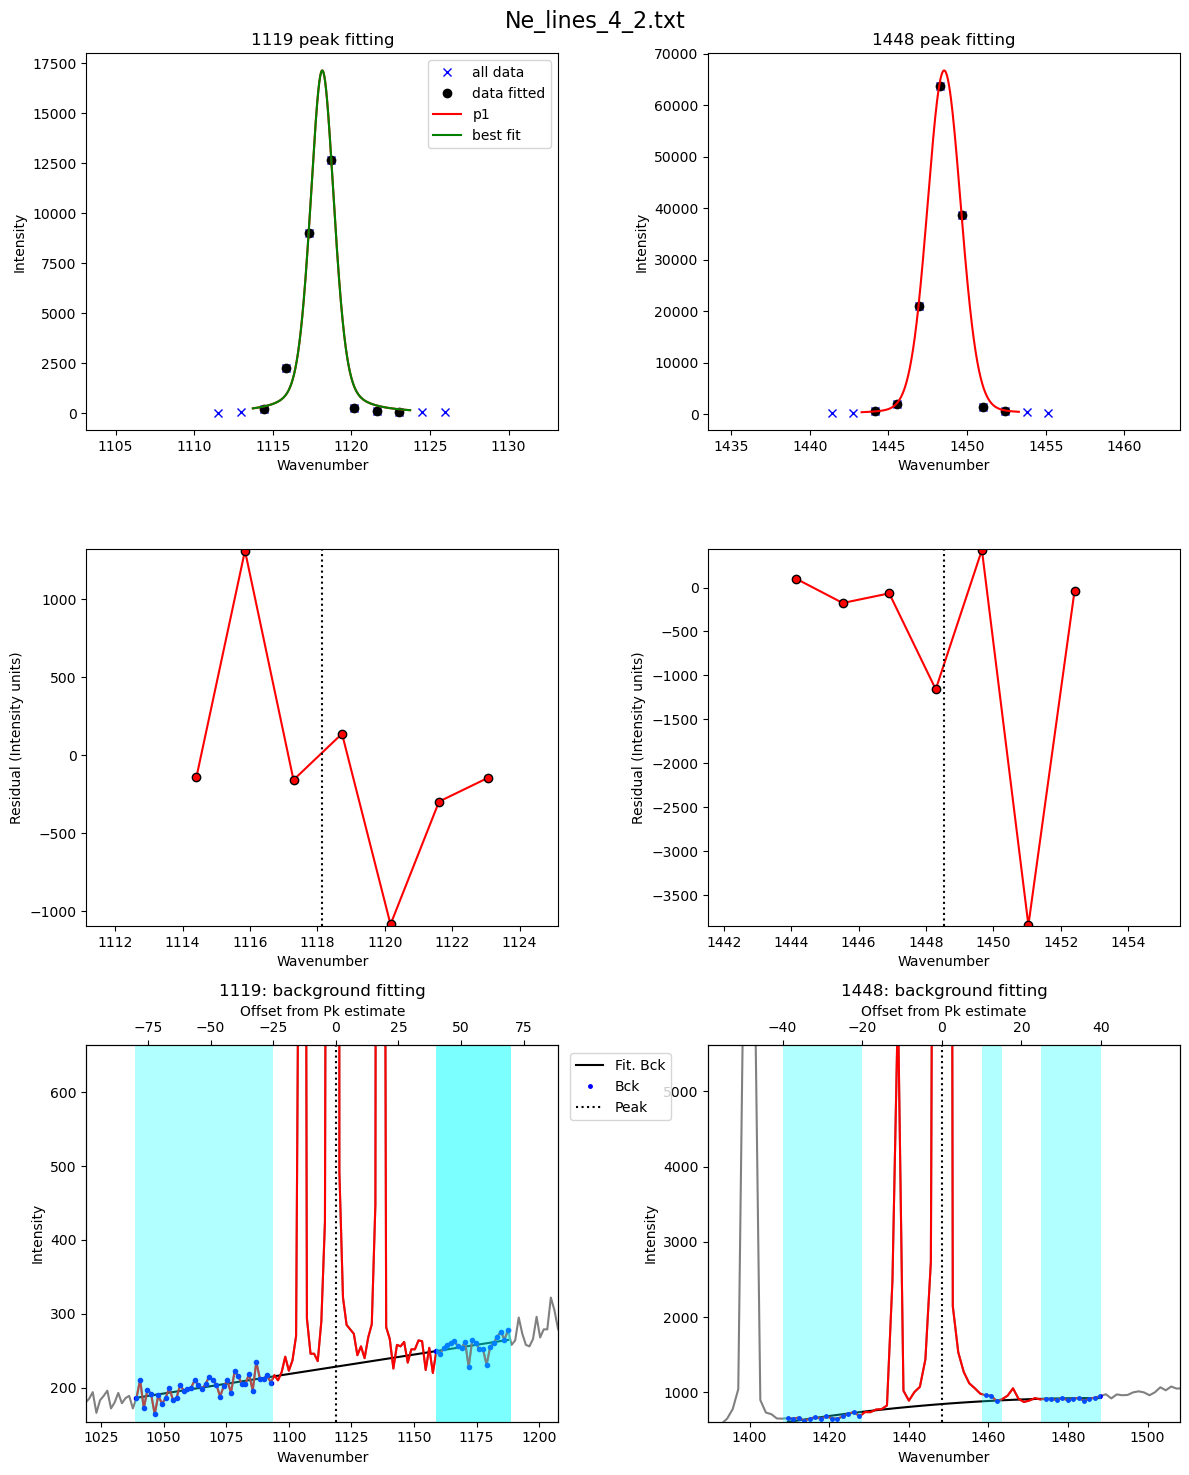

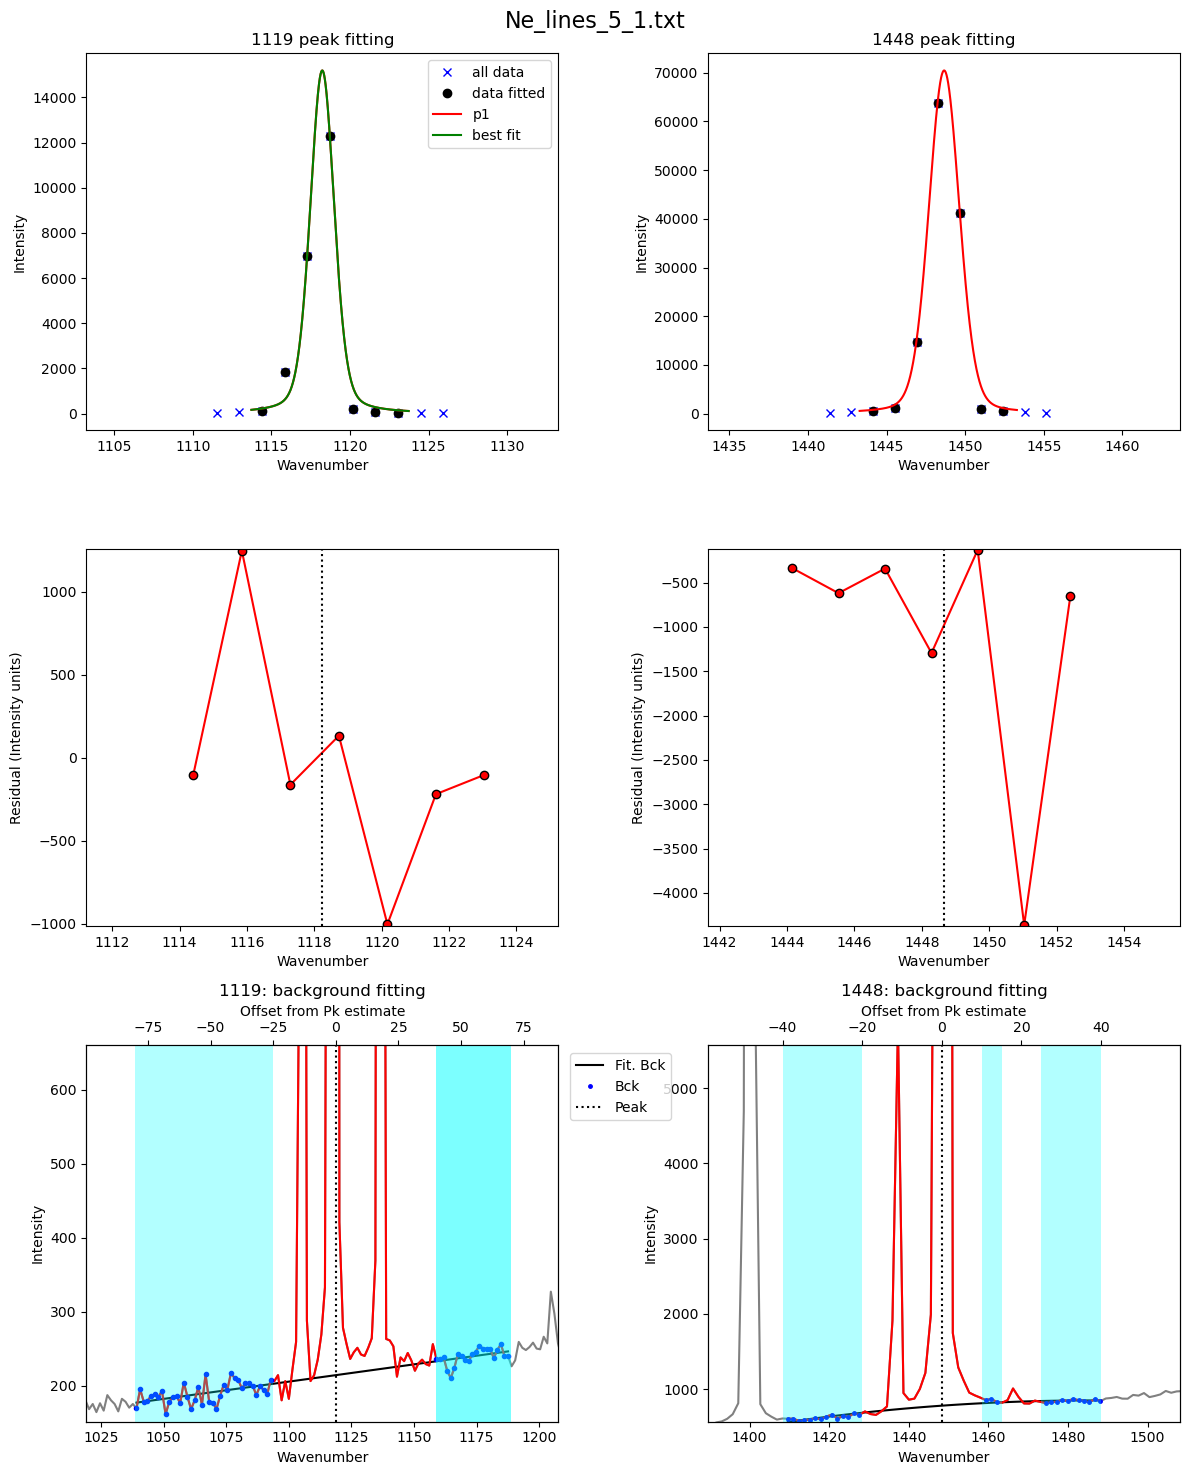

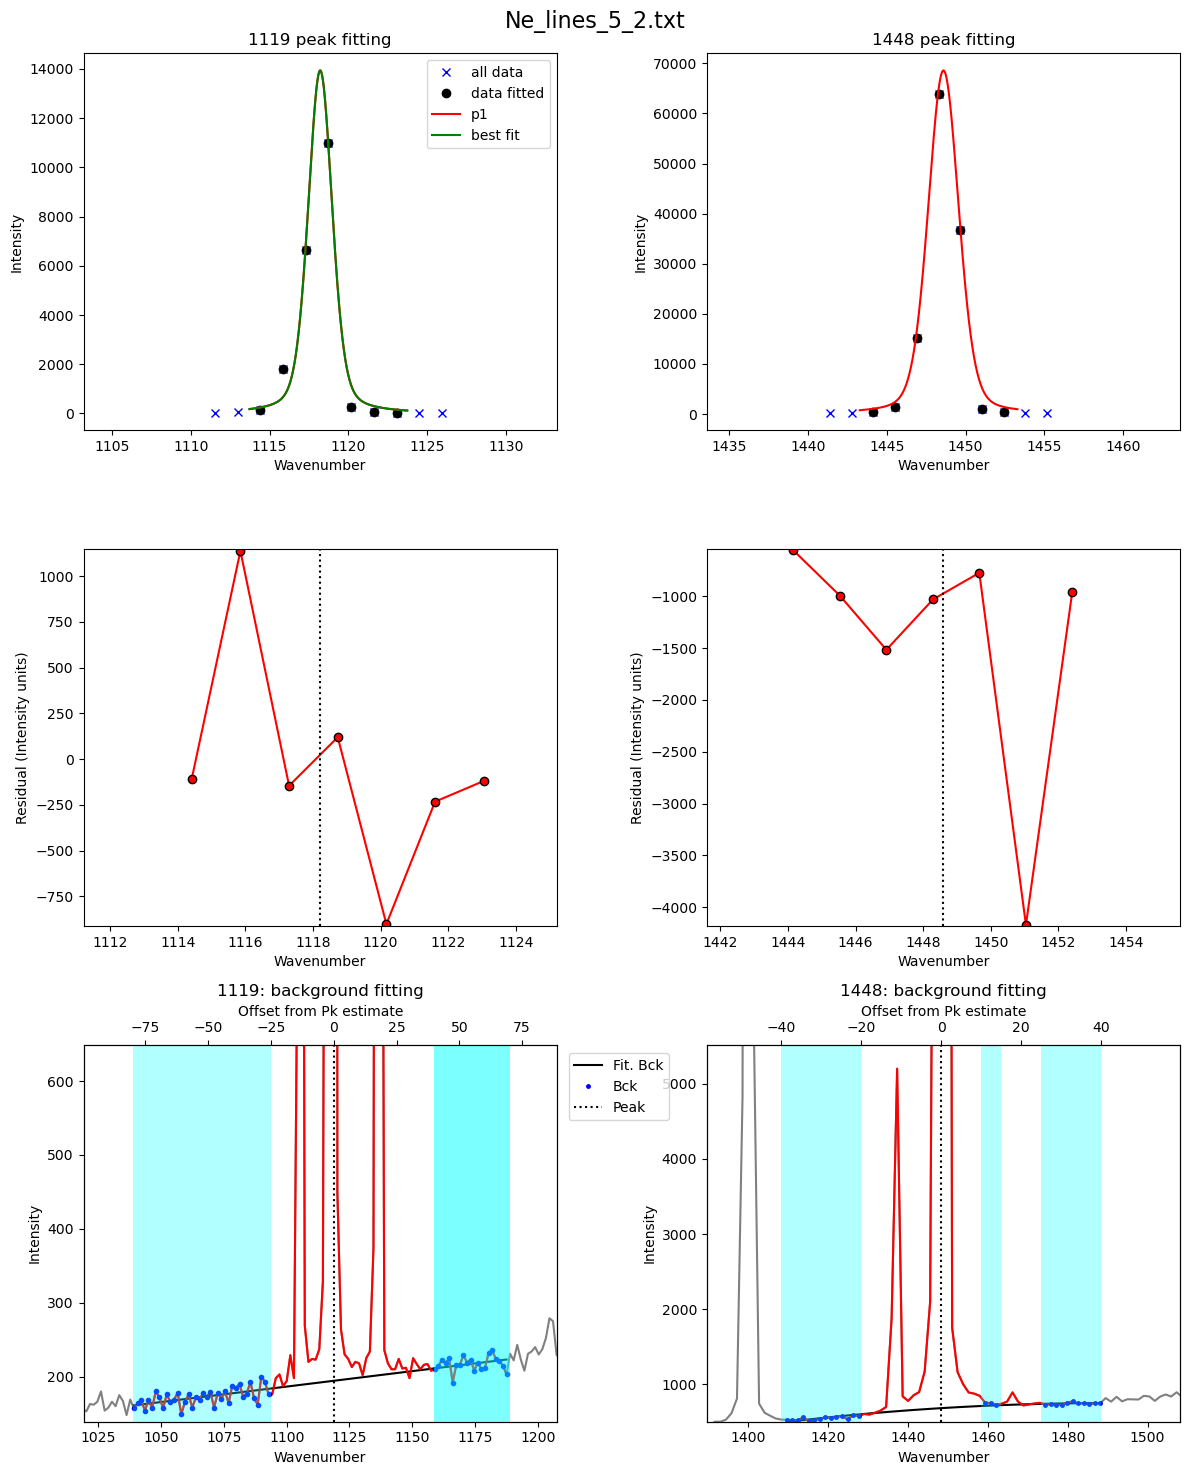

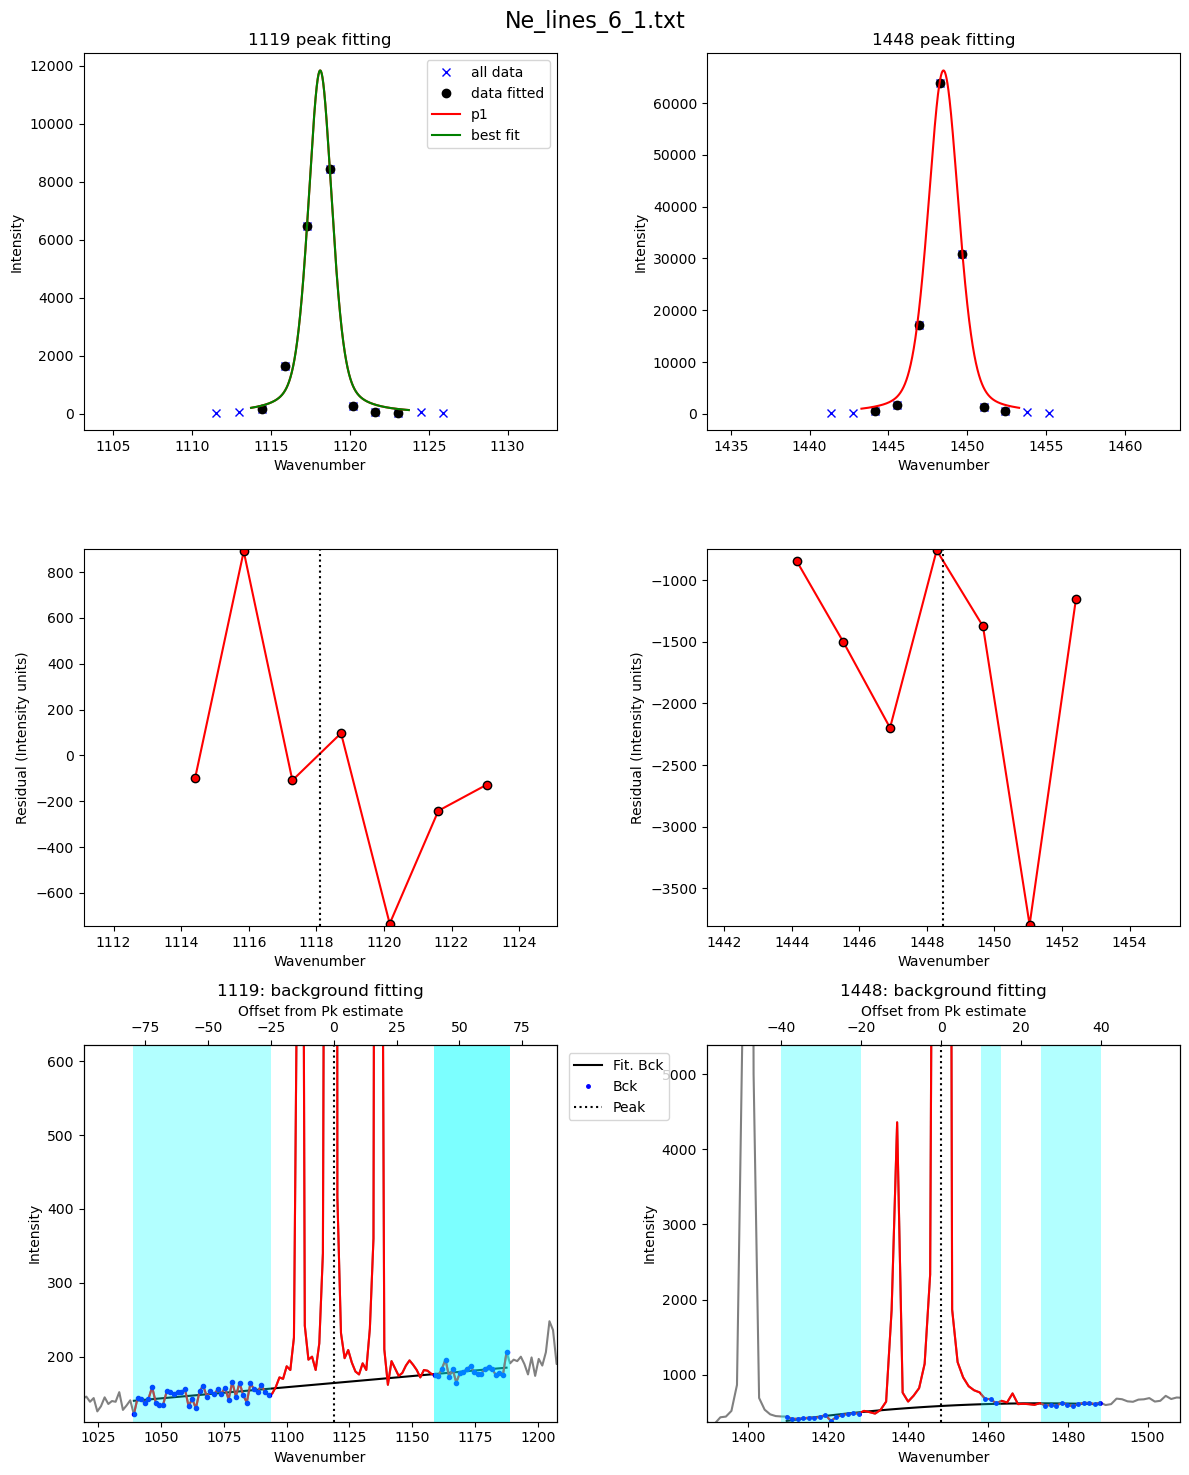

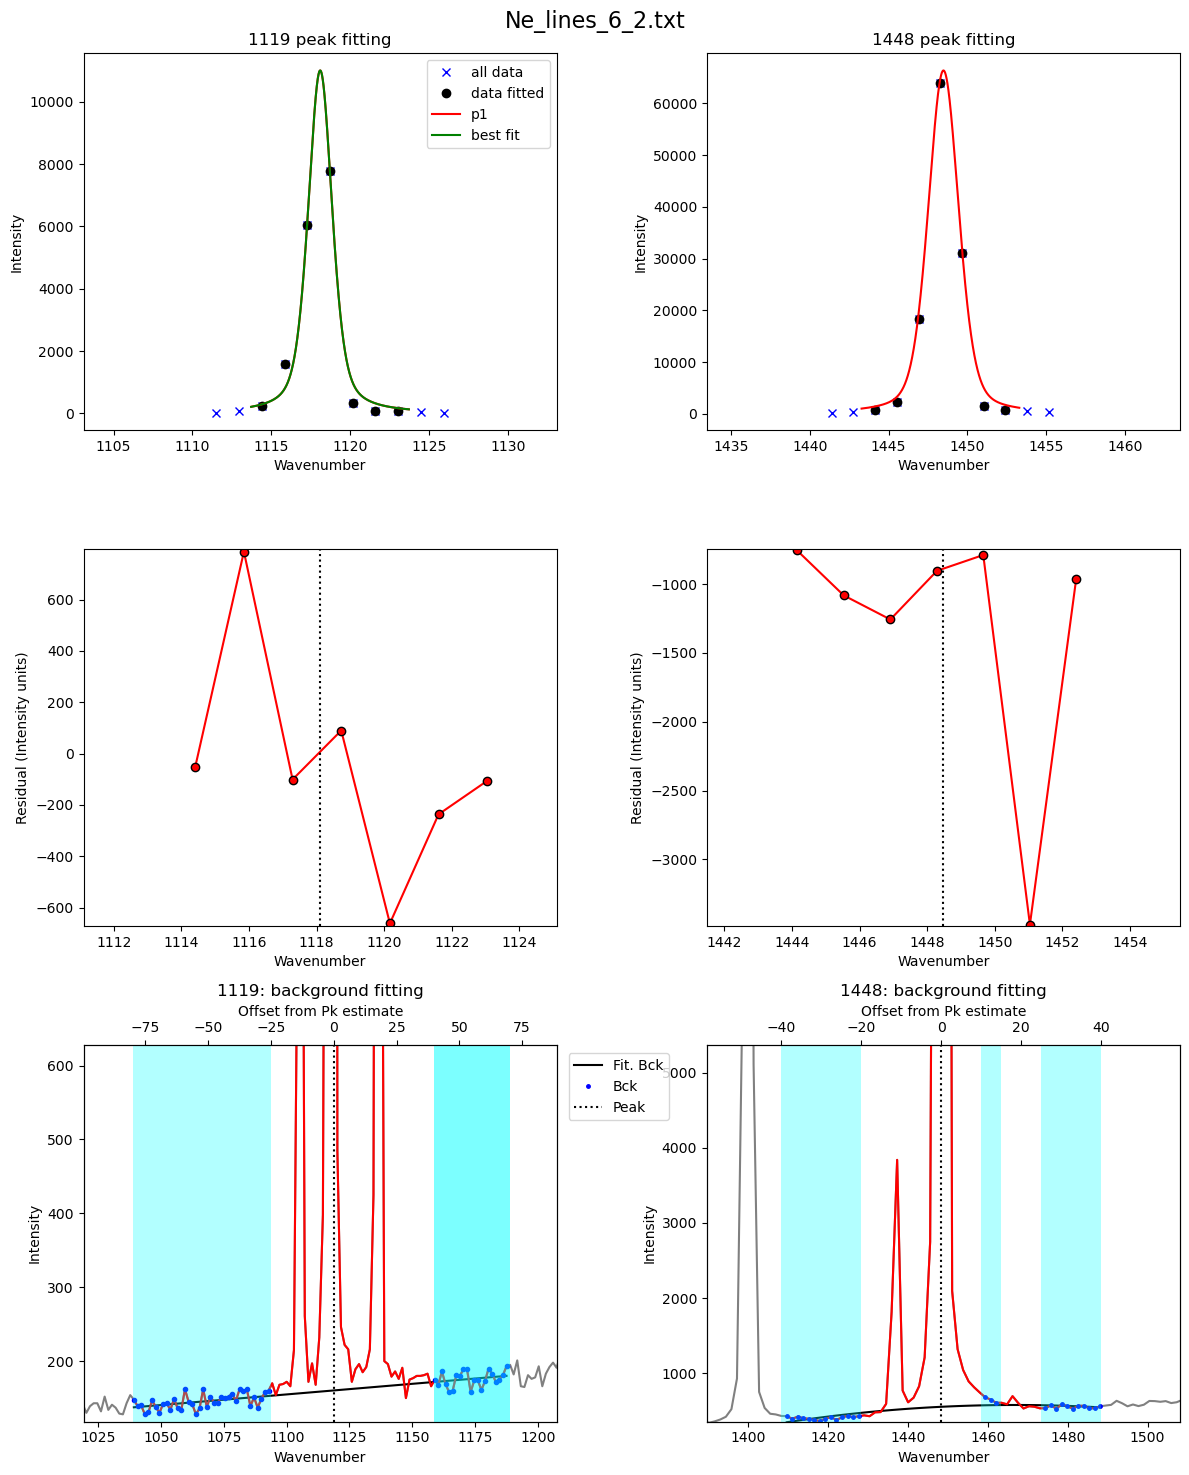

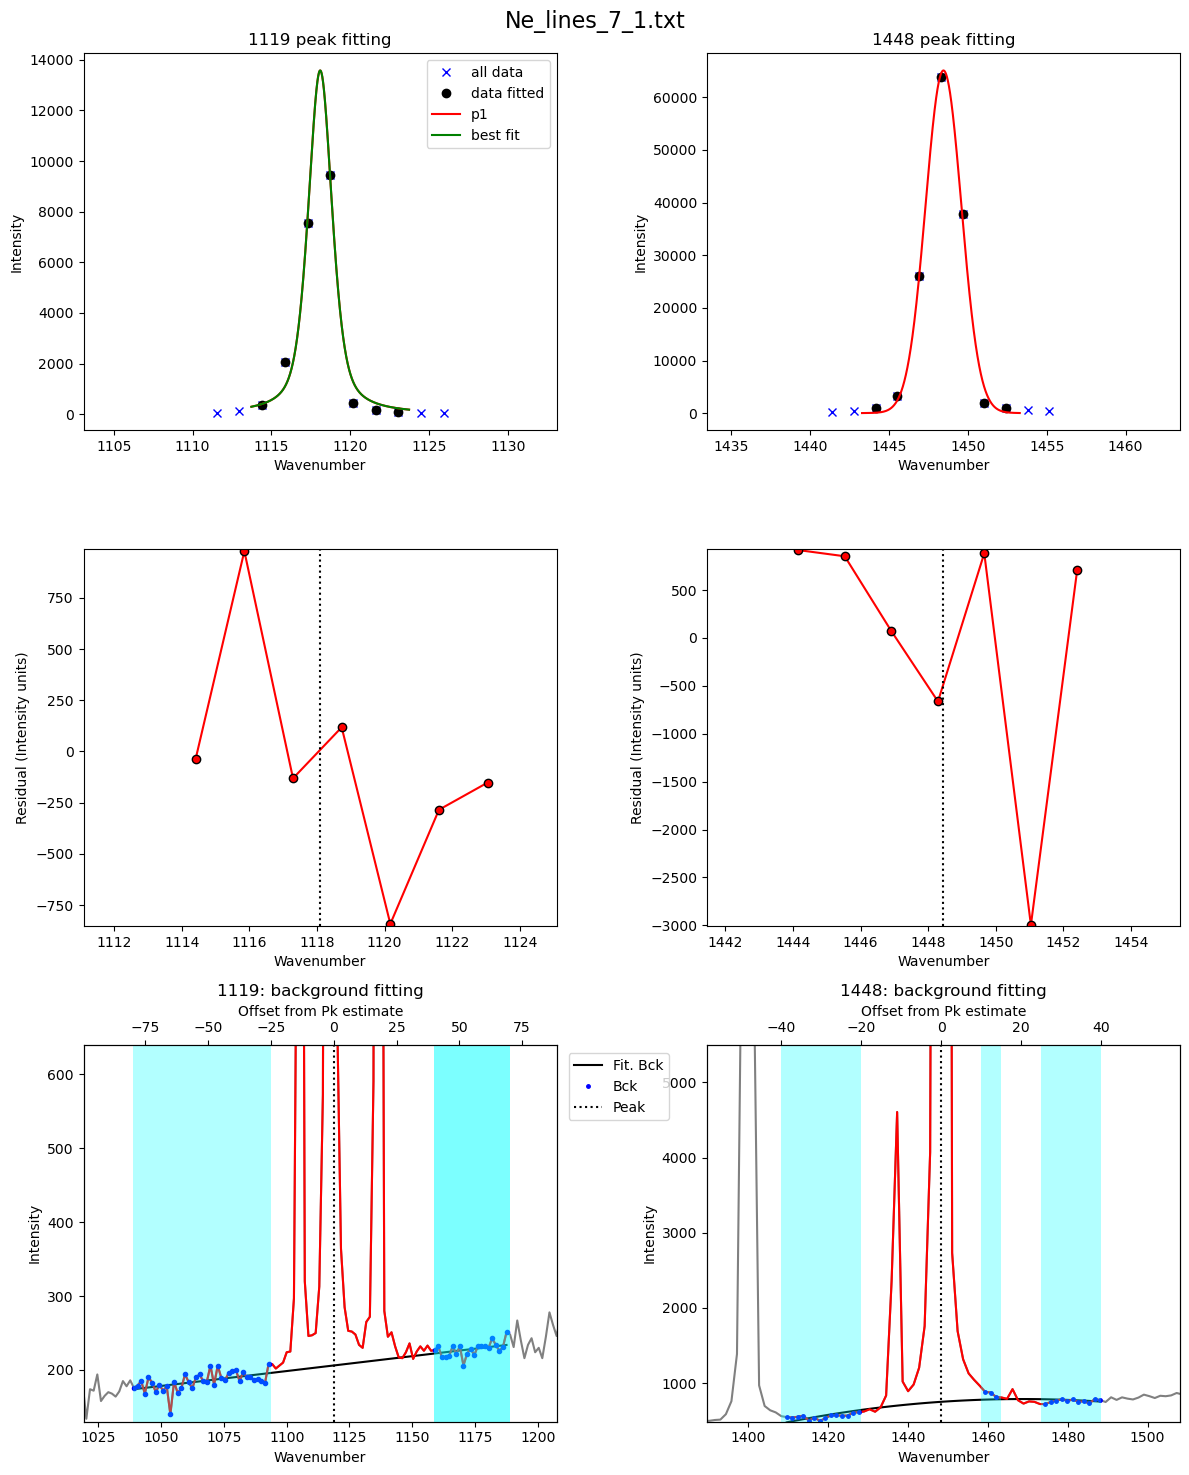

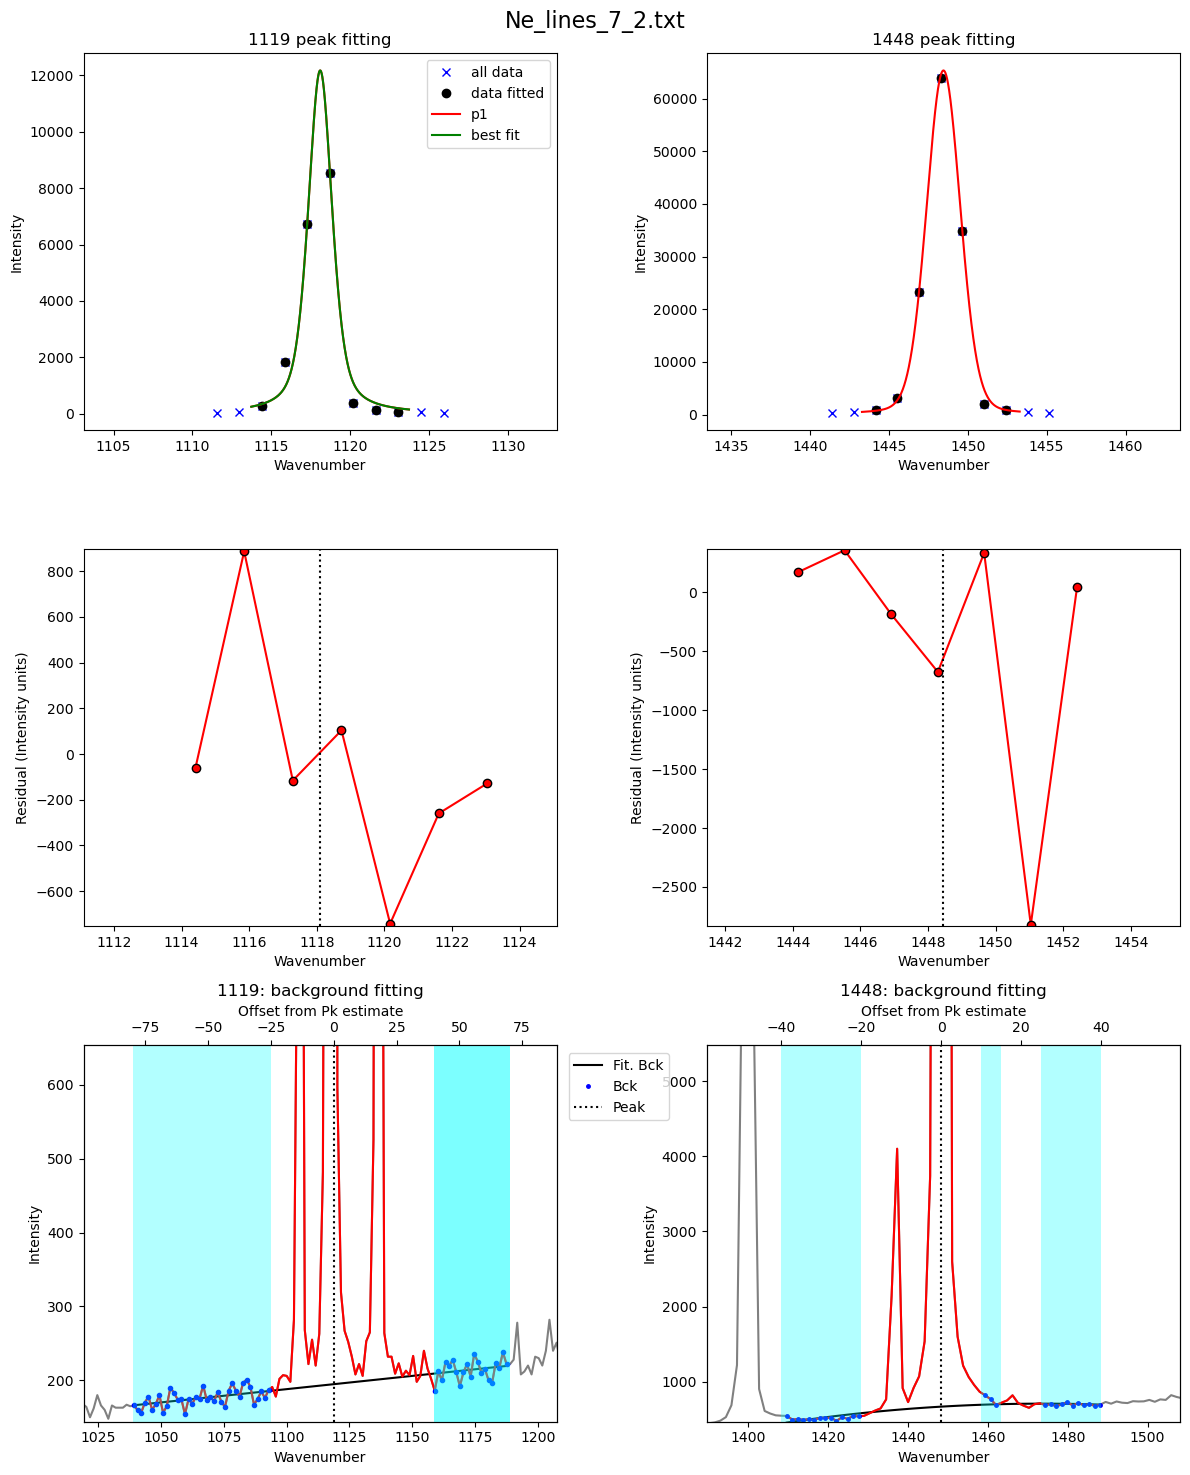

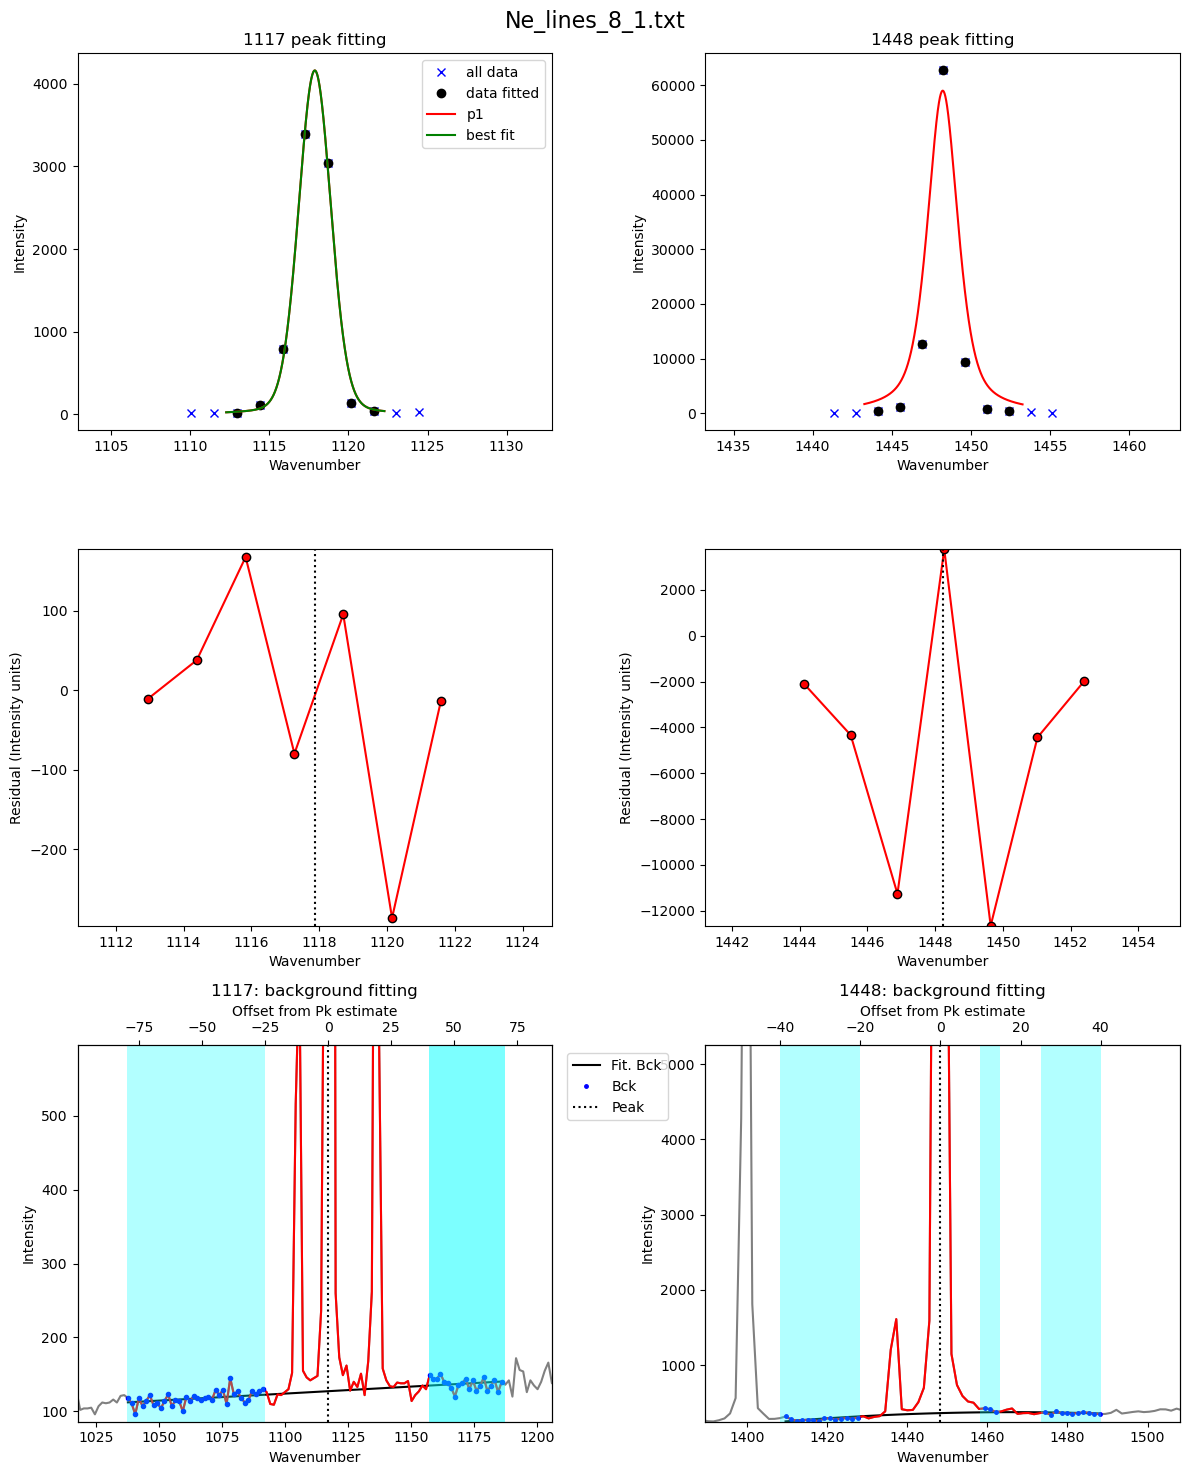

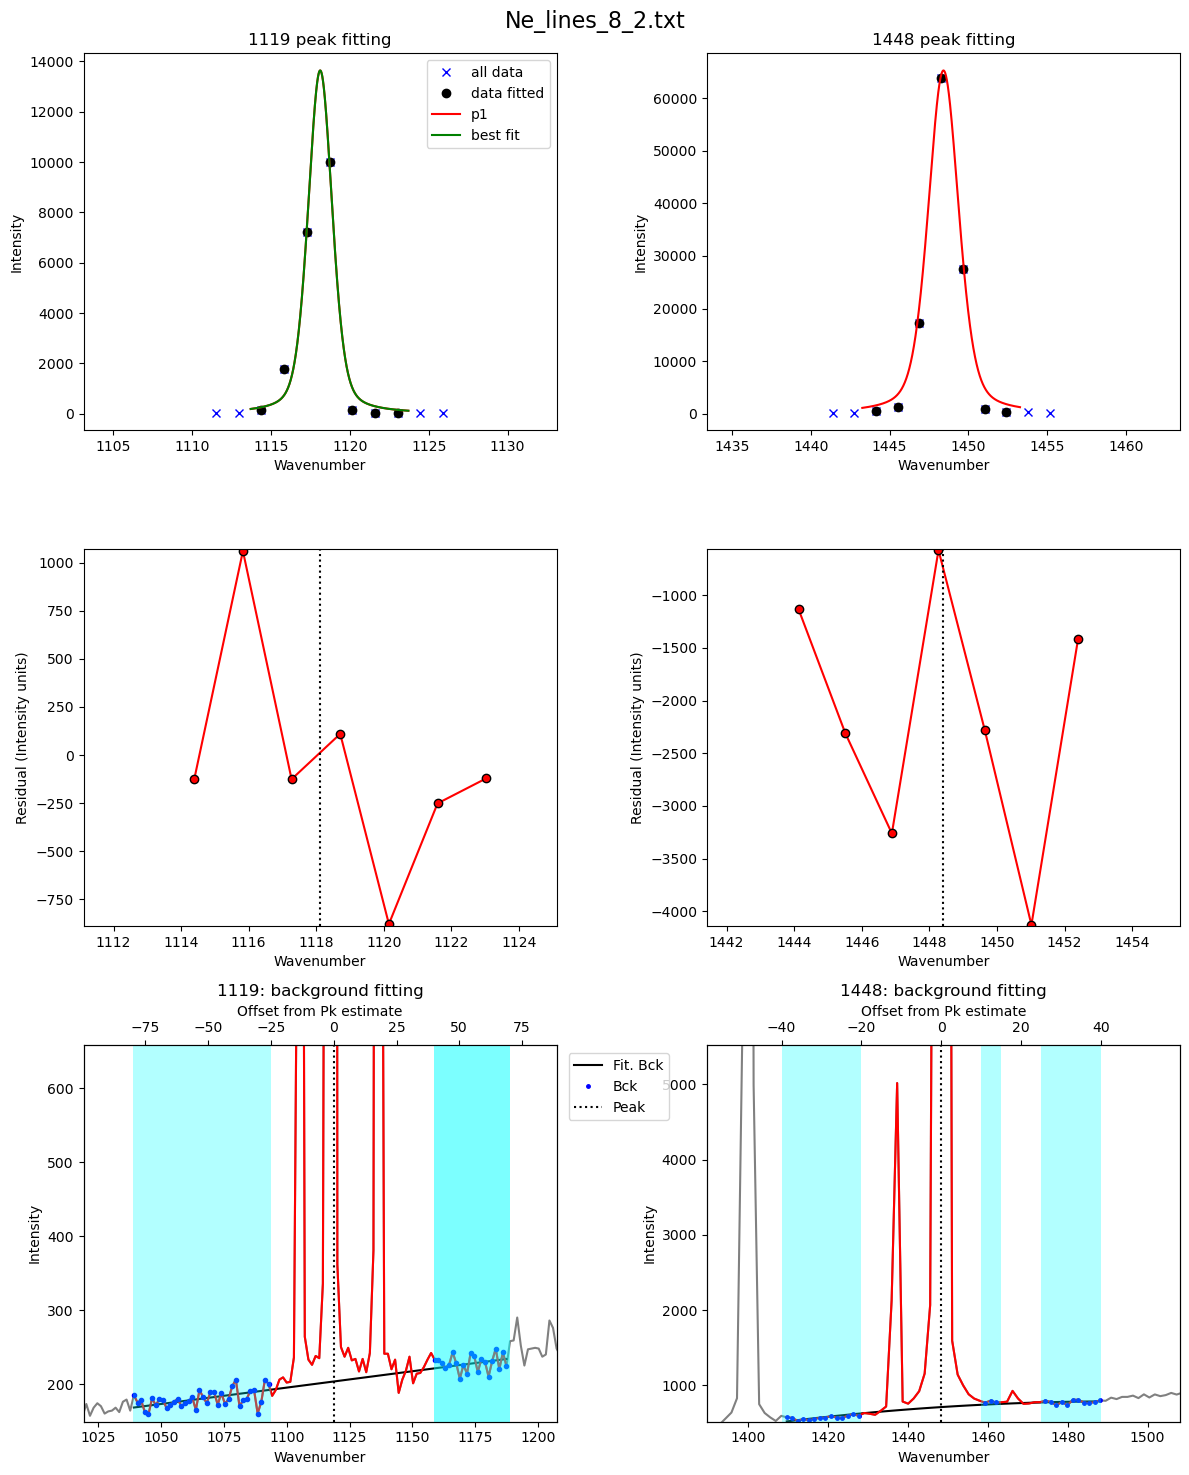

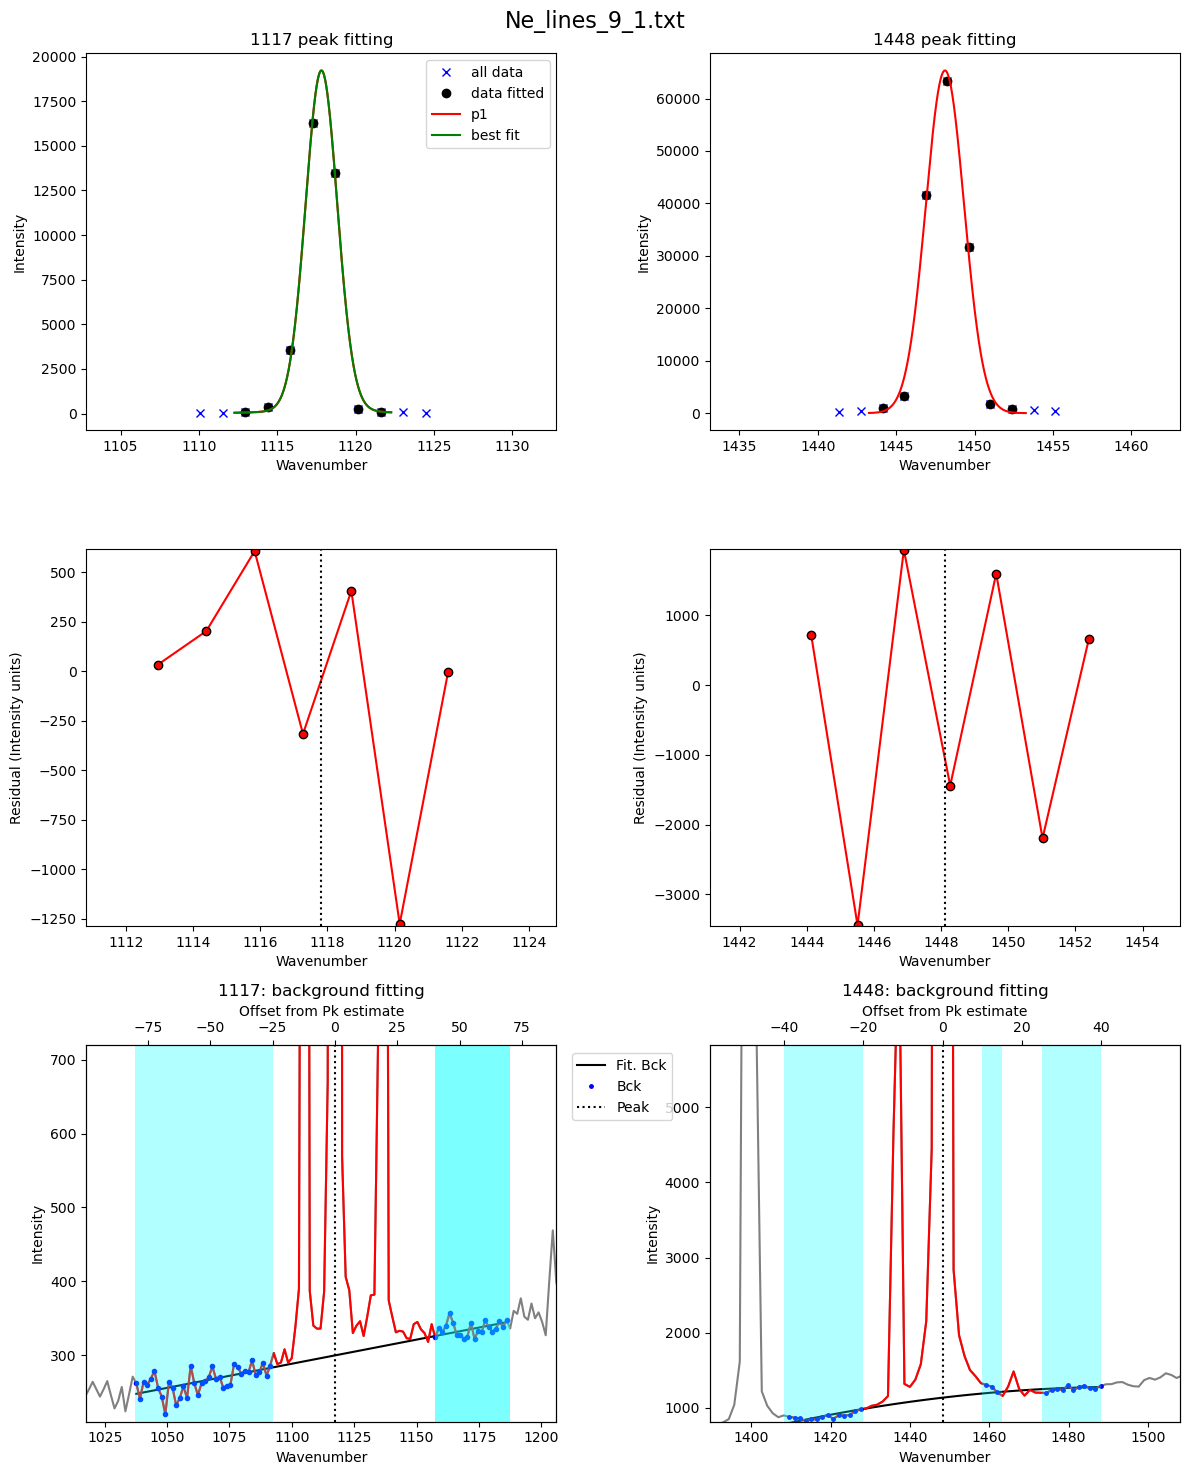

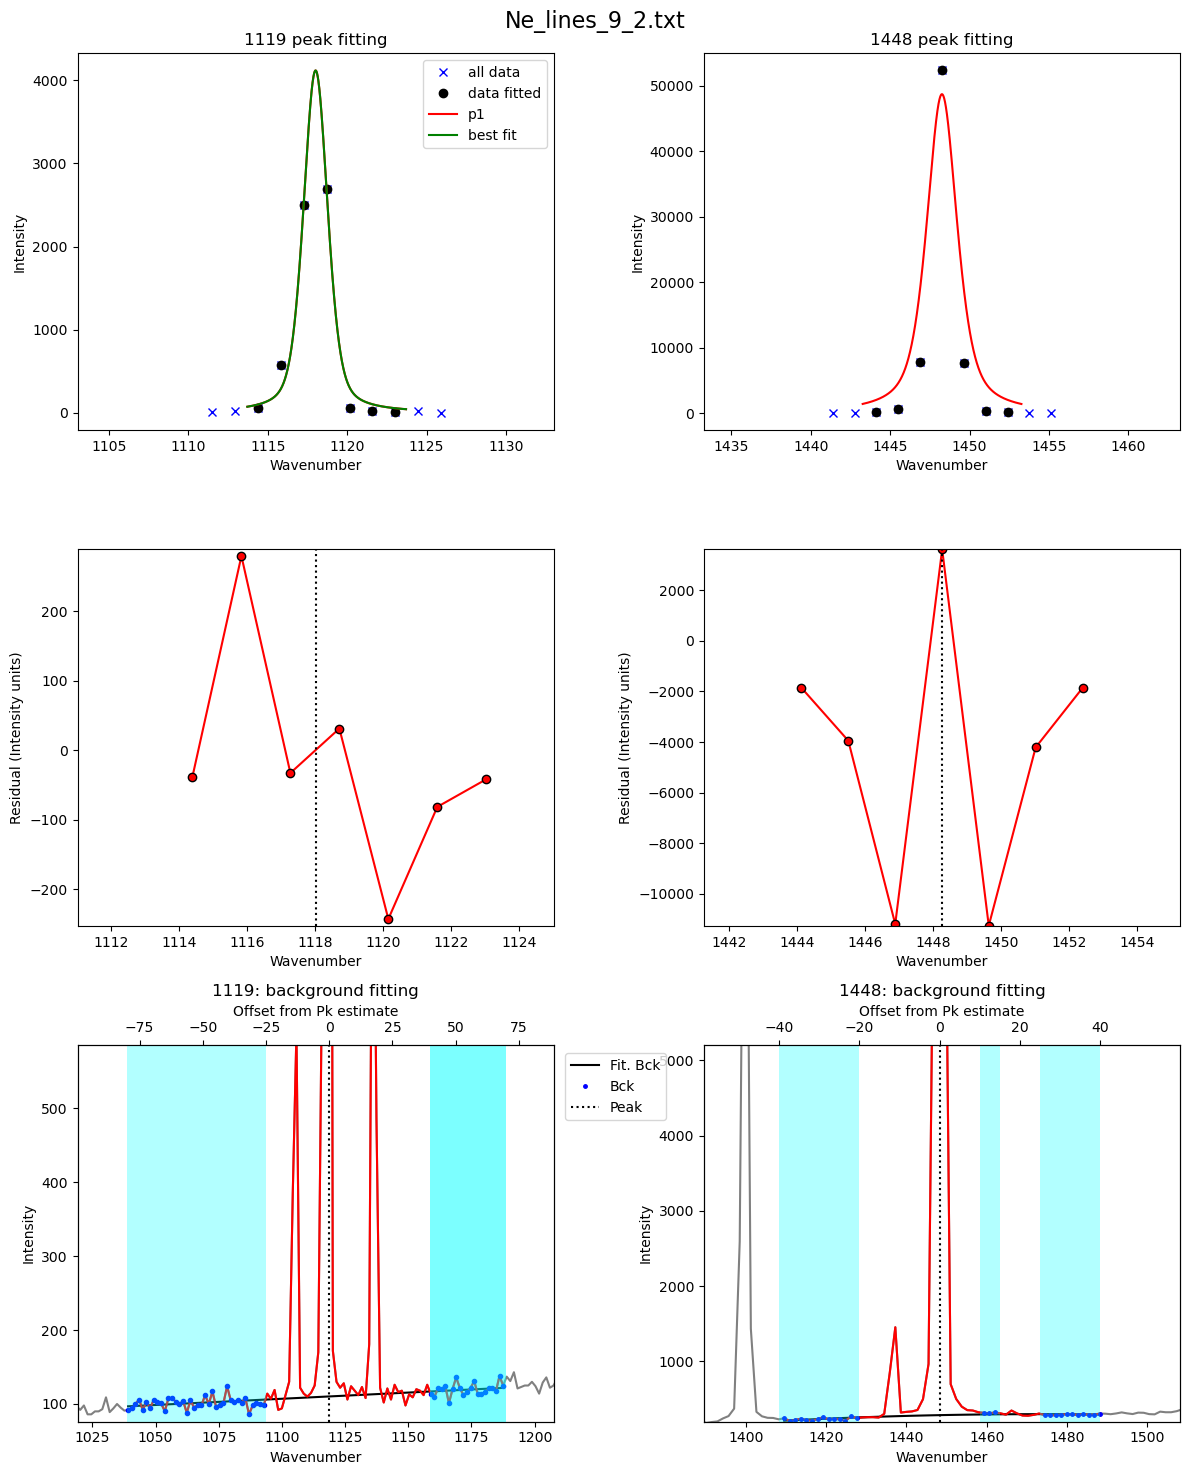

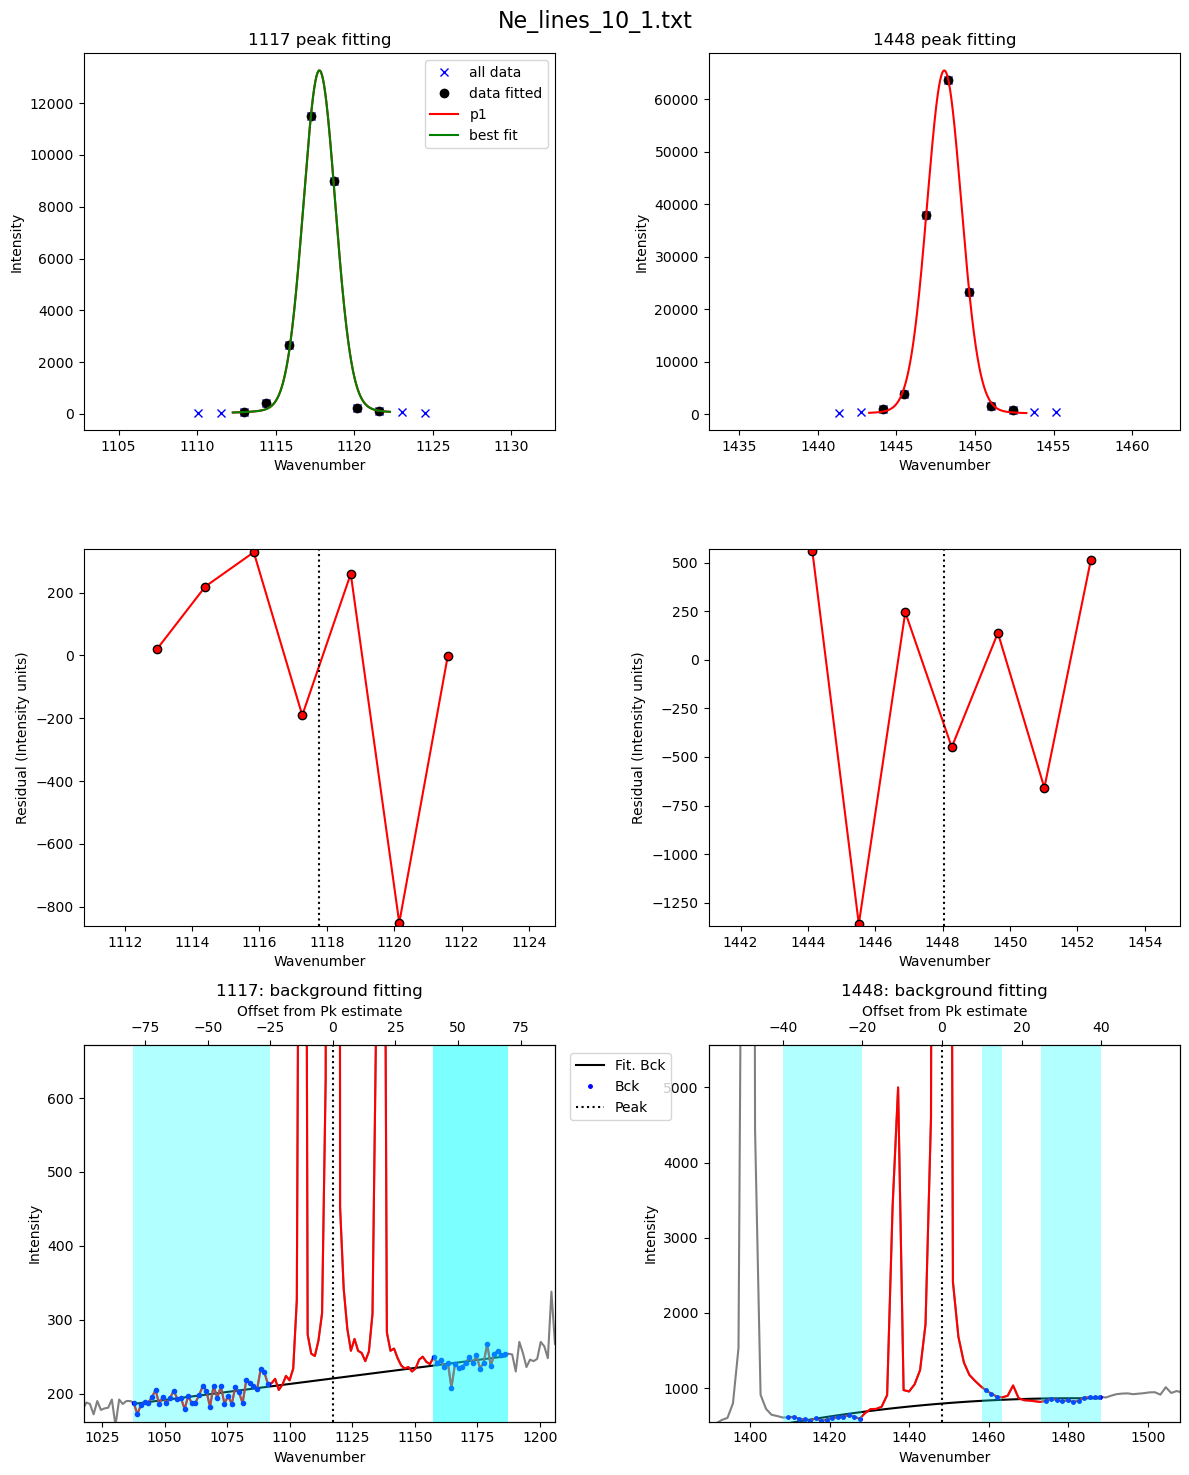

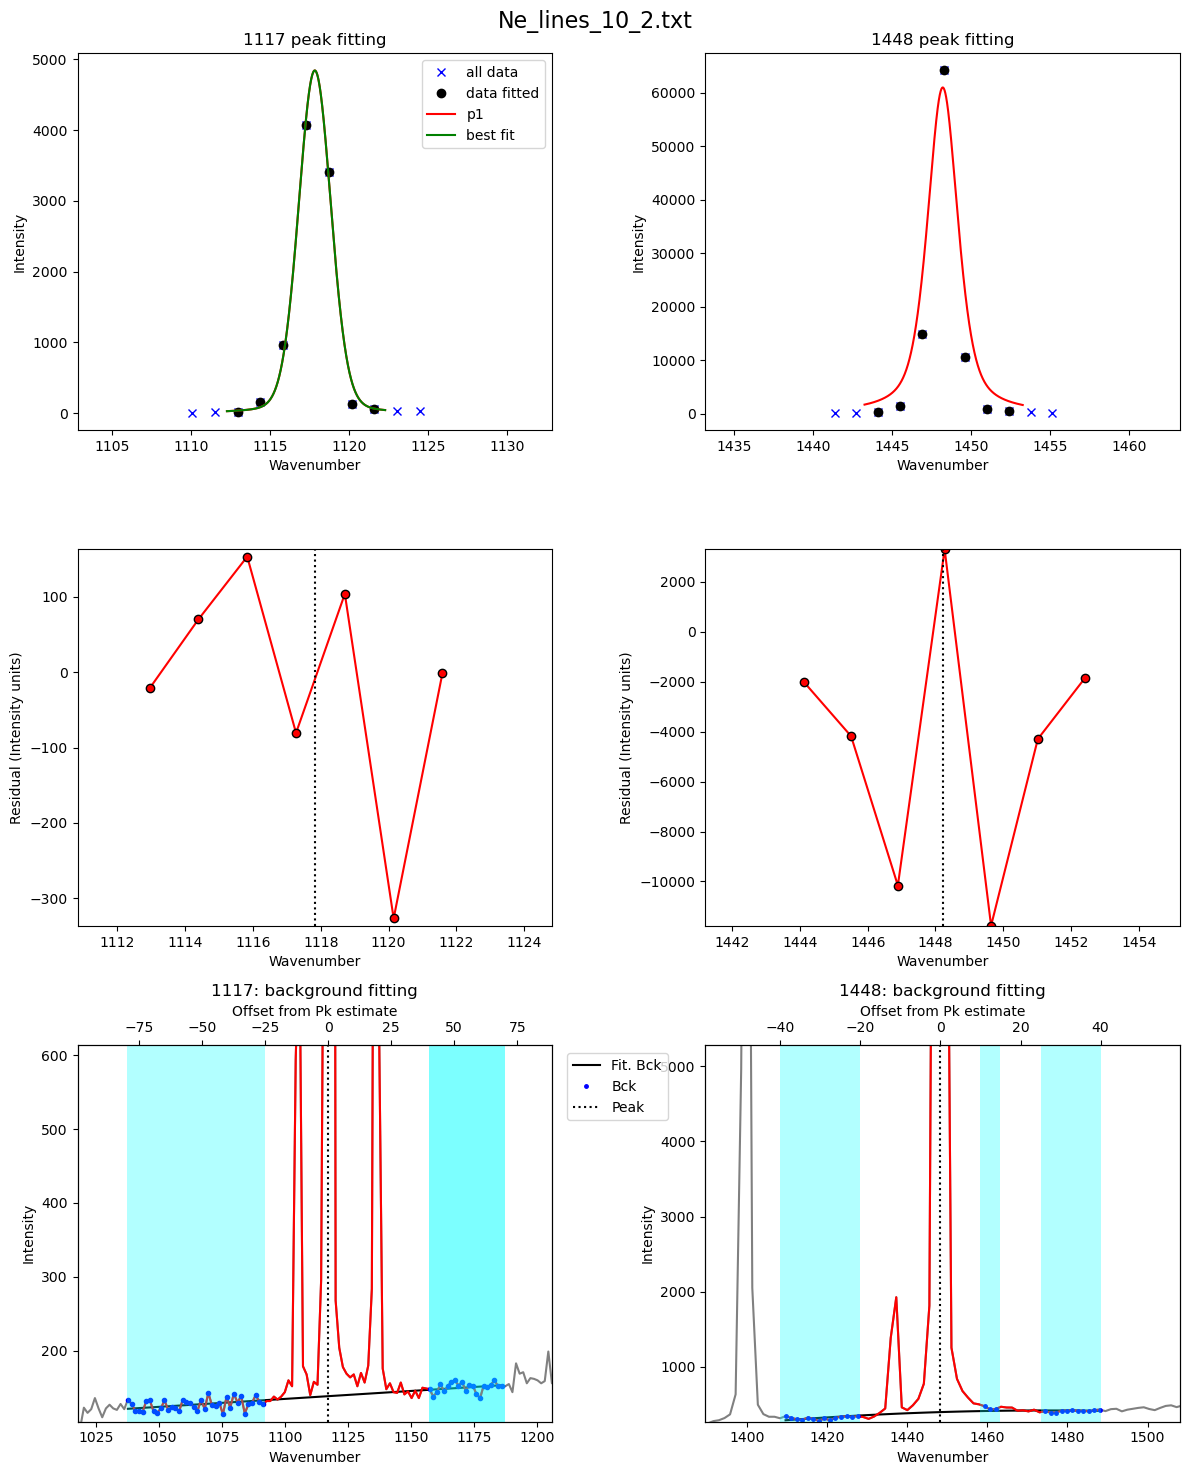

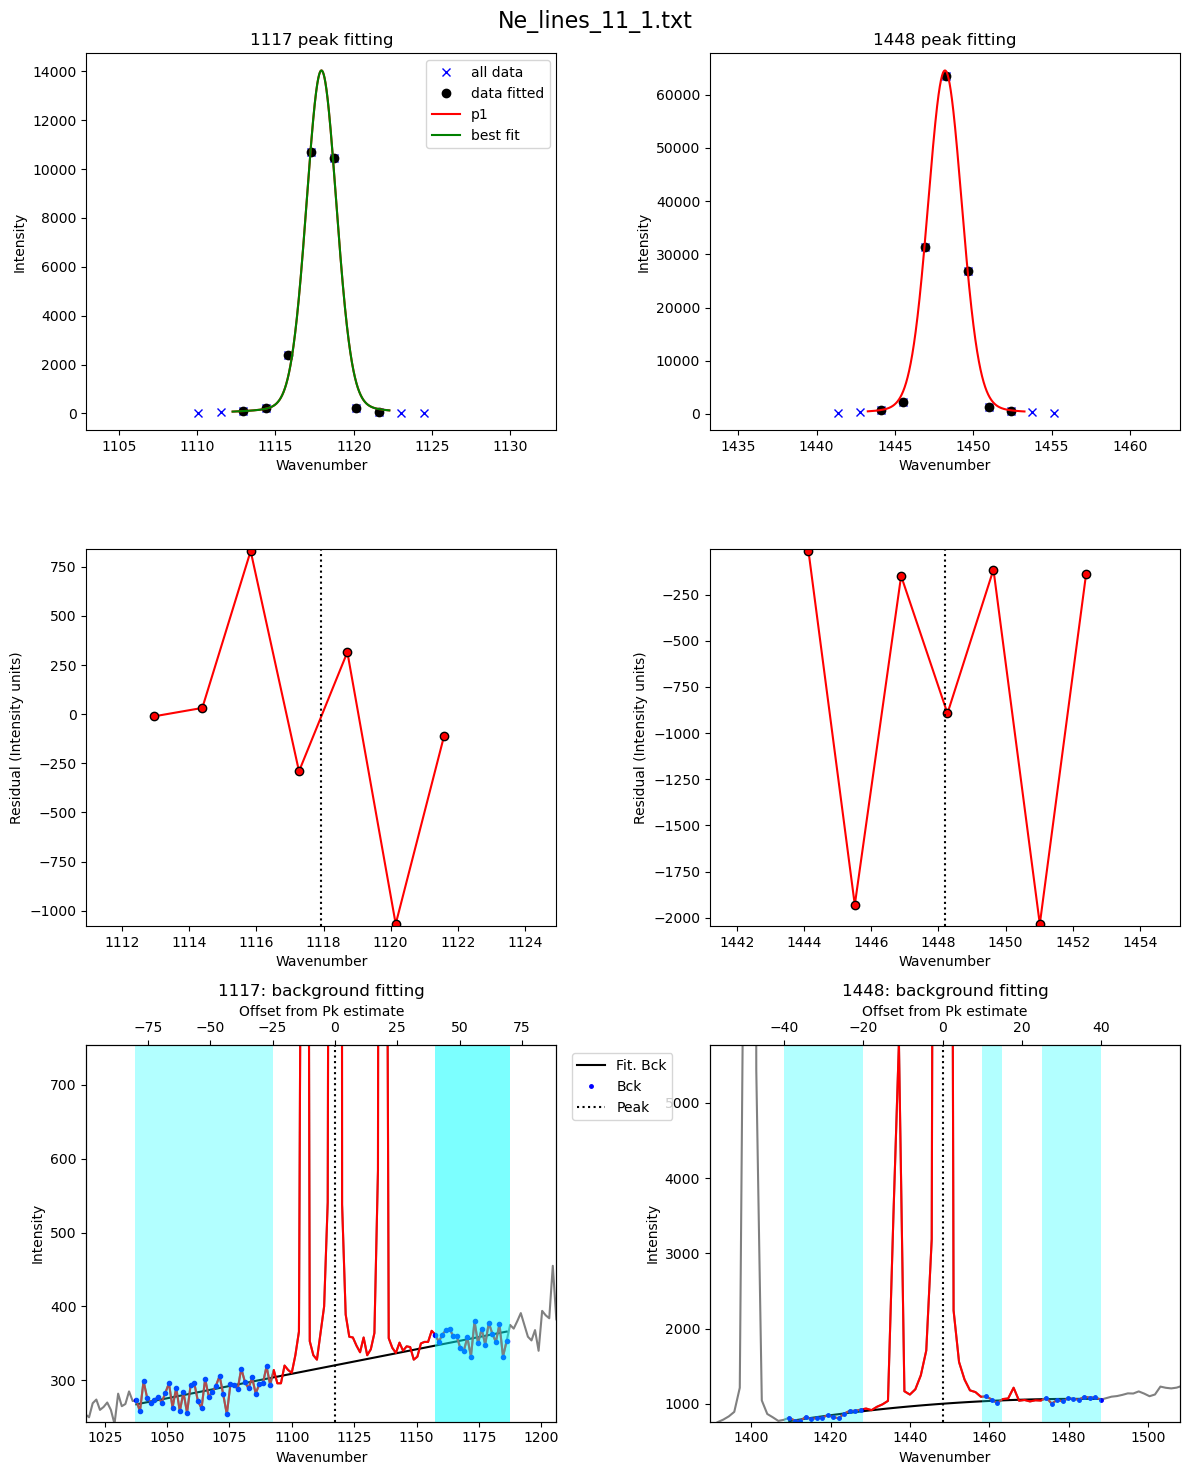

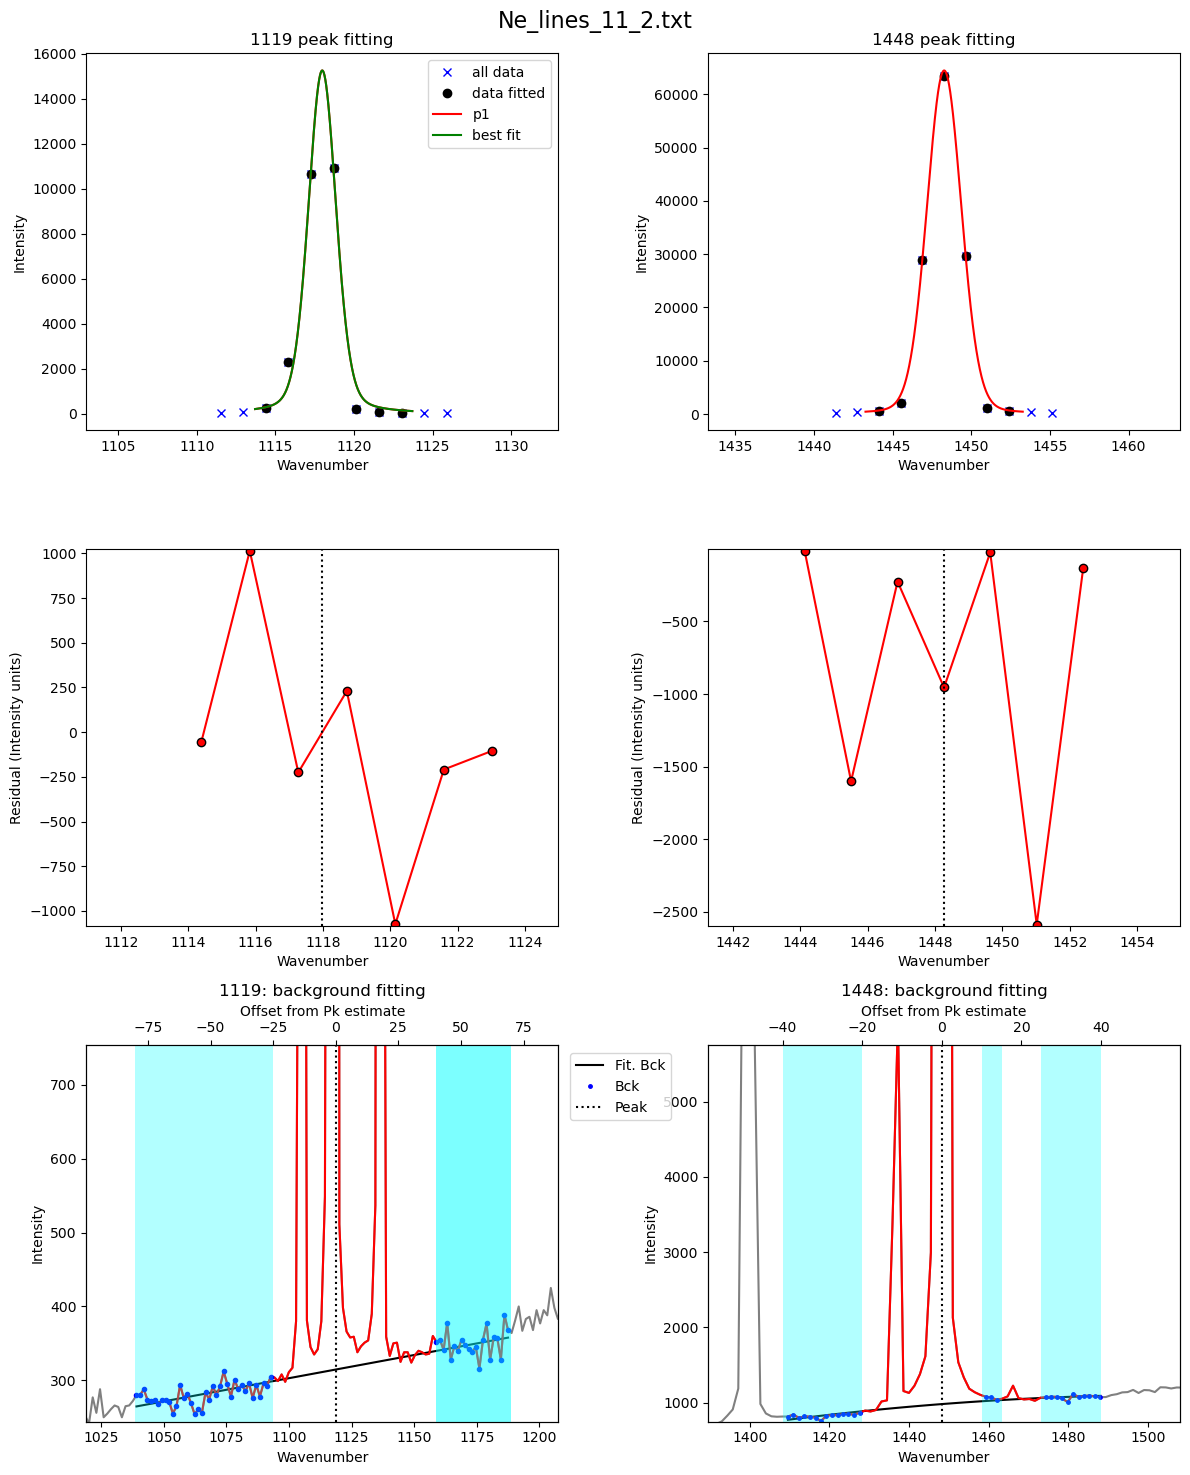

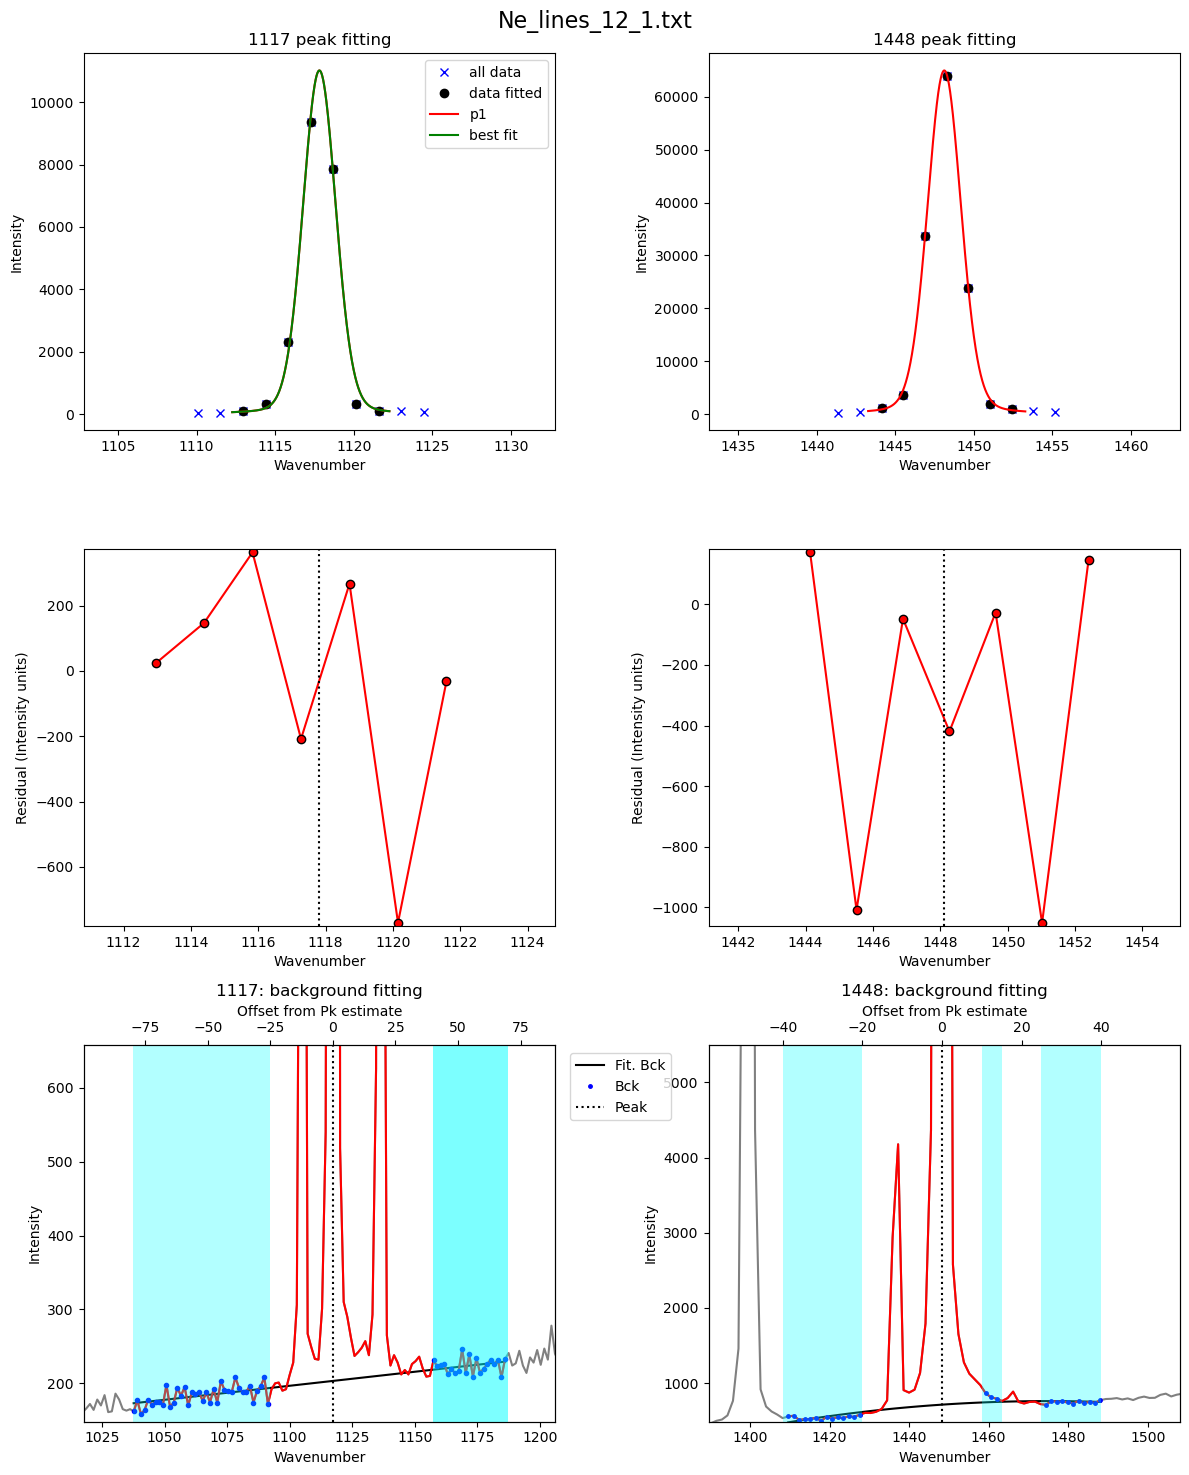

In [23]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True)


## Now extract metadata to get a timestamp for each file
- Many files have no metadata - Here, all we really need is the timestamp. We do this using this function which uses the modificatoin time of the file (in this instance, this is the end of the acquisition)

In [26]:
meta=pf.loop_convert_datastamp_to_metadata(path=spectra_path, 
files=Ne_files, creation=False,
modification=True)
meta

filename             date    Month  Day  power (mW)  Int_time (s)  \
0   Ne_lines_1_1.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_1_2.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_2_1.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_2_2.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_3_1.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_3_2.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_4_1.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_4_2.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_6_1.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_6_2.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_5_1.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_5_2.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_7_1.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_7_2.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_8_1.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_8_2.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_9_1.txt  January 1, 2020  January    1         NaN           NaN   
0   Ne_lines_9_2.txt  January 1, 2020  January    1         NaN           NaN   
0  Ne_lines_10_1.txt  January 1, 2020  January    1         NaN           NaN   
0  Ne_lines_10_2.txt  January 1, 2020  January    1         NaN           NaN   
0  Ne_lines_11_1.txt  January 1, 2020  January    1         NaN           NaN   
0  Ne_lines_11_2.txt  January 1, 2020  January    1         NaN           NaN   
0  Ne_lines_12_1.txt  January 1, 2020  January    1         NaN           NaN   
0  Ne_lines_12_2.txt  January 1, 2020  January    1         NaN           NaN   

   accumulations  Mag (X)  duration 24hr_time  sec since midnight  \
0            NaN      NaN       NaN   1:58:25                7105   
0            NaN      NaN       NaN    2:0:27                7227   
0            NaN      NaN       NaN   2:15:55                8155   
0            NaN      NaN       NaN   2:20:34                8434   
0            NaN      NaN       NaN   2:56:49               10609   
0            NaN      NaN       NaN     3:0:8               10808   
0            NaN      NaN       NaN   3:32:38               12758   
0            NaN      NaN       NaN   3:39:53               13193   
0            NaN      NaN       NaN   4:31:37               16297   
0            NaN      NaN       NaN   4:33:10               16390   
0            NaN      NaN       NaN     4:8:8               14888   
0            NaN      NaN       NaN    4:9:24               14964   
0            NaN      NaN       NaN    5:10:8               18608   
0            NaN      NaN       NaN   5:12:22               18742   
0            NaN      NaN       NaN   5:54:23               21263   
0            NaN      NaN       NaN   5:57:28               21448   
0            NaN      NaN       NaN   6:53:17               24797   
0            NaN      NaN       NaN   6:55:17               24917   
0            NaN      NaN       NaN    7:23:4               26584   
0            NaN      NaN       NaN   7:25:23               26723   
0            NaN      NaN       NaN   8:13:31               29611   
0            NaN      NaN       NaN   8:15:45               29745   
0            NaN      NaN       NaN    9:4:28               32668   
0            NaN      NaN       NaN    9:6:35               32795   

   Spectral Center  
0              NaN  
0              NaN  
0              NaN  
0              NaN  
0              NaN  
0              NaN  
0              NaN  
0              NaN  
0              NaN  
0              NaN  
0              NaN  
0       

In [27]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext='.txt')
file_m

good job, no duplicate file names


array(['Ne_lines_1_1', 'Ne_lines_1_2', 'Ne_lines_2_1', 'Ne_lines_2_2',
       'Ne_lines_3_1', 'Ne_lines_3_2', 'Ne_lines_4_1', 'Ne_lines_4_2',
       'Ne_lines_6_1', 'Ne_lines_6_2', 'Ne_lines_5_1', 'Ne_lines_5_2',
       'Ne_lines_7_1', 'Ne_lines_7_2', 'Ne_lines_8_1', 'Ne_lines_8_2',
       'Ne_lines_9_1', 'Ne_lines_9_2', 'Ne_lines_10_1', 'Ne_lines_10_2',
       'Ne_lines_11_1', 'Ne_lines_11_2', 'Ne_lines_12_1', 'Ne_lines_12_2'],
      dtype=object)

In [28]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext='.txt')
file_s

good job, no duplicate file names


array(['Ne_lines_12_2', 'Ne_lines_1_1', 'Ne_lines_1_2', 'Ne_lines_2_1',
       'Ne_lines_2_2', 'Ne_lines_3_1', 'Ne_lines_3_2', 'Ne_lines_4_1',
       'Ne_lines_4_2', 'Ne_lines_5_1', 'Ne_lines_5_2', 'Ne_lines_6_1',
       'Ne_lines_6_2', 'Ne_lines_7_1', 'Ne_lines_7_2', 'Ne_lines_8_1',
       'Ne_lines_8_2', 'Ne_lines_9_1', 'Ne_lines_9_2', 'Ne_lines_10_1',
       'Ne_lines_10_2', 'Ne_lines_11_1', 'Ne_lines_11_2', 'Ne_lines_12_1'],
      dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [29]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [30]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

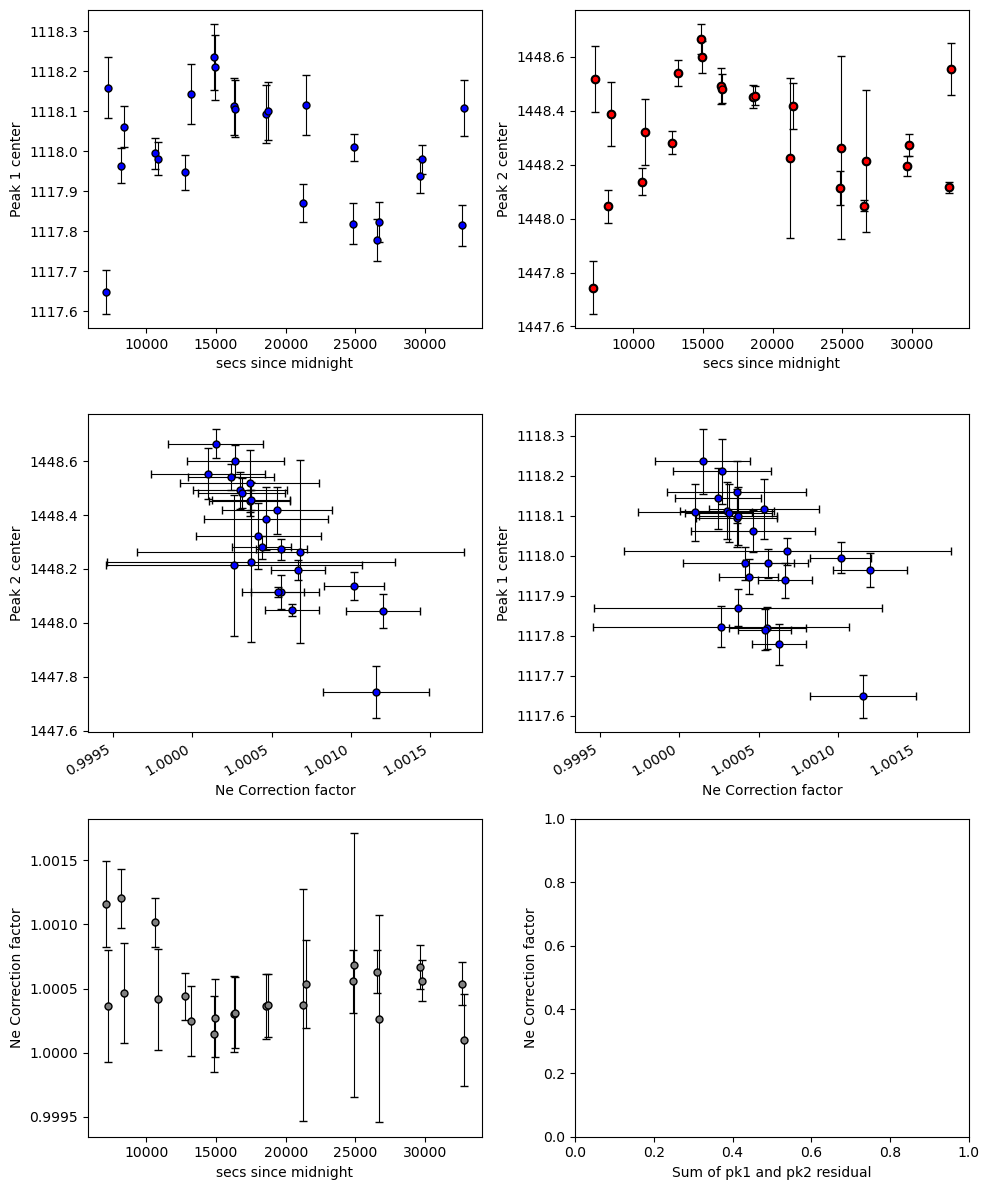

In [31]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

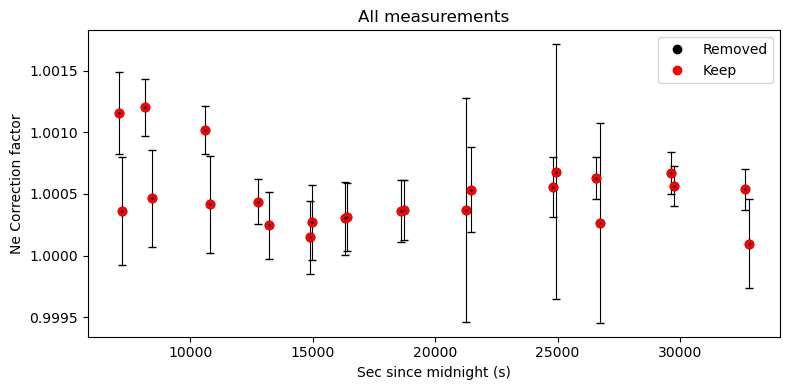

In [32]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

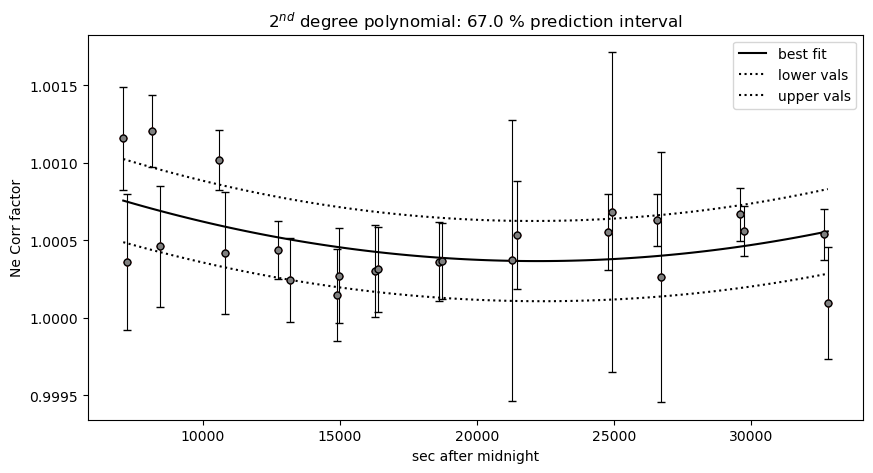

In [33]:

## Lets get filtered ones
keep=filt>0
pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=2, CI=0.67, pkl_name='Neon_corr_model.pkl')
